<a href="https://colab.research.google.com/github/desstaw/Shortcut_Learning/blob/main/MNIST_28_alexnet_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchextractor

In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset, random_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import torch.nn as nn


In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/mnist"

Mounted at /content/drive


In [ ]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

## Dataset and Model setup

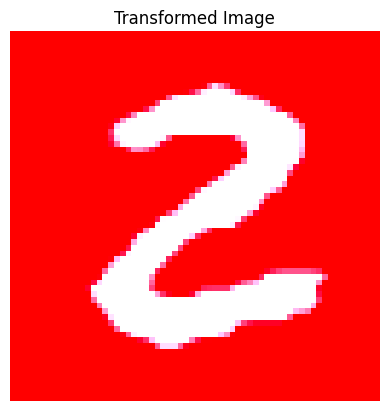

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms


image_file_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/train/class_2/2_2.png'


img = Image.open(image_file_path).convert("RGB")


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images
])


transformed_img = transform(img)

# Convert the tensor to a NumPy array and transpose
img_np = transformed_img.numpy().transpose((1, 2, 0))

# Display the image
plt.imshow(img_np)
plt.title('Transformed Image')
plt.axis('off')
plt.show()


A data processing class that matches the second version of the customized alexnet mentioned before with 3 RGB channels and 1000 outputs

In [ ]:

import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision import transforms

class MnistDataset(Dataset):
    def __init__(self, path: str = None, is_two: int = None, data_files=None, labels=None, group_labels=None):
        self.resize_shape = (64, 64)  # Target shape for resizing images
        self.transform = transforms.Compose([
            transforms.Resize(self.resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images
        ])

        if path:  # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_two = is_two
            self.labels = [is_two] * len(self.data_files) if is_two is not None else labels
            self.group_labels = group_labels if group_labels else [None] * len(self.data_files)
        else:  # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.group_labels = group_labels if group_labels else [None] * len(data_files)
            self.is_two = is_two

    def __getitem__(self, i):
        # Read in the image
        img = Image.open(os.path.join(self.path, self.data_files[i])).convert("RGB")  # Convert to RGB
        if self.transform:
            img = self.transform(img)  # Apply transformations

        # Determine the label
        is_two = self.is_two if self.is_two is not None else self.labels[i]
        group_label = self.group_labels[i]

        return (img, is_two, group_label)

    def __len__(self):  # Returns the total number of images in the dataset.
        return len(self.data_files)



1. Deep Learning for Image Classification: A Comprehensive Review
(Alzubaidi, Lina, et al. "Review of deep learning: Concepts, CNN architectures, challenges, applications, future directions." Journal of Big Data 8.1 (2021): 53.)
2. Deep Convolutional Neural Networks for Large-Scale Image Recognition
(Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems 25 (2012): 1097-1105)

Also a custom alexnet but with 1000 outputs as the standard one and 3 input RGB channels and not grayscale like the original one also

In [ ]:

import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, width_mult=1):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # 96*55*55 (for 224x224 input)
            nn.MaxPool2d(kernel_size=3, stride=2),  # 96*27*27
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # 256*27*27
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*13*13
            nn.ReLU(inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # 384*13*13
            nn.ReLU(inplace=True),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # 256*13*13
            nn.MaxPool2d(kernel_size=3, stride=2),  # 256*6*6
            nn.ReLU(inplace=True),
        )
        self.fc1 = nn.Linear(256 * 1 * 1, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)  # 1000 output

    def forward(self, x):
        x = self.layer1(x)
        #print("After layer1:", x.mean().item(), x.std().item())
        x = self.layer2(x)
        #print("After layer2:", x.mean().item(), x.std().item())
        x = self.layer3(x)
        #print("After layer3:", x.mean().item(), x.std().item())
        x = self.layer4(x)
        #print("After layer4:", x.mean().item(), x.std().item())
        x = self.layer5(x)
        #print("After layer5:", x.mean().item(), x.std().item())
        x = x.view(-1, 256 * 1 * 1)
        x = self.fc1(x)
        #print("After fc1:", x.mean().item(), x.std().item())
        x = self.fc2(x)
        #print("After fc2:", x.mean().item(), x.std().item())
        x = self.fc3(x)
        #print("After fc3 (output):", x.mean().item(), x.std().item())
        return x


# Example usage:
# model = AlexNet()
# print(model)


## Function for Training

Another function for training that matches the second custom alexnet with the 3 RGB channels and 1000 outputs

In [ ]:

import torch.optim as optim
import torch.nn.functional as F
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, resume_training=False):
    since = time.time()
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Initialize best_model_wts with the current model state

    # Initialize lists to track loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels, _ in tqdm(dataloaders[phase]):

                if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                    print("NaN or Inf found in input data!")
                    #continue  # Skip this batch if invalid values are found

                inputs = inputs.to(device)
                labels = labels.to(device)  # No need to convert labels for CrossEntropyLoss

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Use argmax for multi-class classification
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().numpy())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().numpy())

                if epoch_acc > best_accuracy:
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_accuracy = epoch_acc
                    print("Saving Best Model with Validation Accuracy: ", epoch_acc.item())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_accuracy:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plot the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    return model


## Train

### Original

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0'
#two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
#zero_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'

#Test
test_two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))

dataset_test_two_bg = MnistDataset(path=test_two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_bg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_two_org))



# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_bg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 9504
num_val: 2377
num_test: 1032


Epoch 1/10
----------


100%|██████████| 149/149 [01:52<00:00,  1.33it/s]


train Loss: 2.3233 Acc: 0.8941


100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


val Loss: 0.0257 Acc: 0.9891
Saving Best Model with Validation Accuracy:  0.9890618426588137
Epoch 2/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.77it/s]


train Loss: 0.0151 Acc: 0.9960


100%|██████████| 38/38 [00:09<00:00,  4.03it/s]


val Loss: 0.0170 Acc: 0.9954
Saving Best Model with Validation Accuracy:  0.9953723180479597
Epoch 3/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.85it/s]


train Loss: 0.0093 Acc: 0.9979


100%|██████████| 38/38 [00:06<00:00,  5.56it/s]


val Loss: 0.0143 Acc: 0.9962
Saving Best Model with Validation Accuracy:  0.9962137147665124
Epoch 4/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.82it/s]


train Loss: 0.0067 Acc: 0.9988


100%|██████████| 38/38 [00:08<00:00,  4.66it/s]


val Loss: 0.0121 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974758098443416
Epoch 5/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.81it/s]


train Loss: 0.0050 Acc: 0.9994


100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


val Loss: 0.0111 Acc: 0.9975
Epoch 6/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.68it/s]


train Loss: 0.0038 Acc: 0.9998


100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


val Loss: 0.0102 Acc: 0.9975
Epoch 7/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.62it/s]


train Loss: 0.0032 Acc: 0.9999


100%|██████████| 38/38 [00:08<00:00,  4.62it/s]


val Loss: 0.0104 Acc: 0.9975
Epoch 8/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.76it/s]


train Loss: 0.0025 Acc: 1.0000


100%|██████████| 38/38 [00:07<00:00,  4.76it/s]


val Loss: 0.0096 Acc: 0.9975
Epoch 9/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.83it/s]


train Loss: 0.0022 Acc: 0.9999


100%|██████████| 38/38 [00:06<00:00,  5.55it/s]


val Loss: 0.0101 Acc: 0.9975
Epoch 10/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.85it/s]


train Loss: 0.0019 Acc: 1.0000


100%|██████████| 38/38 [00:08<00:00,  4.53it/s]


val Loss: 0.0088 Acc: 0.9975
Training complete in 7m 52s
Best Validation Accuracy: 0.9975


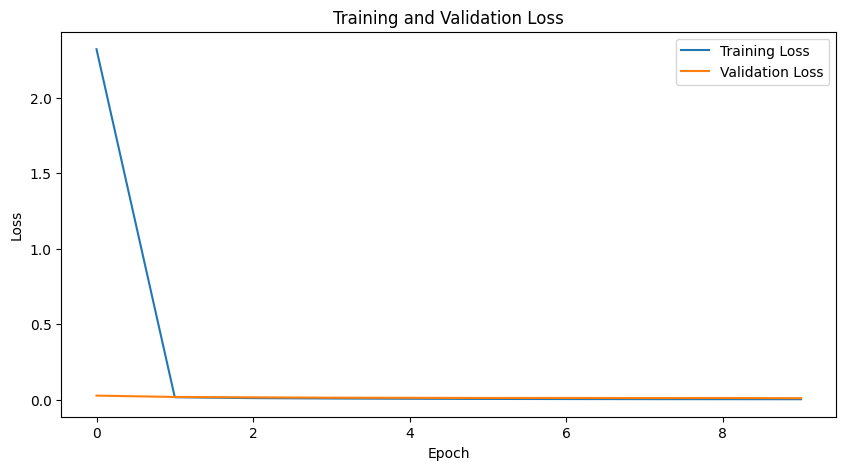

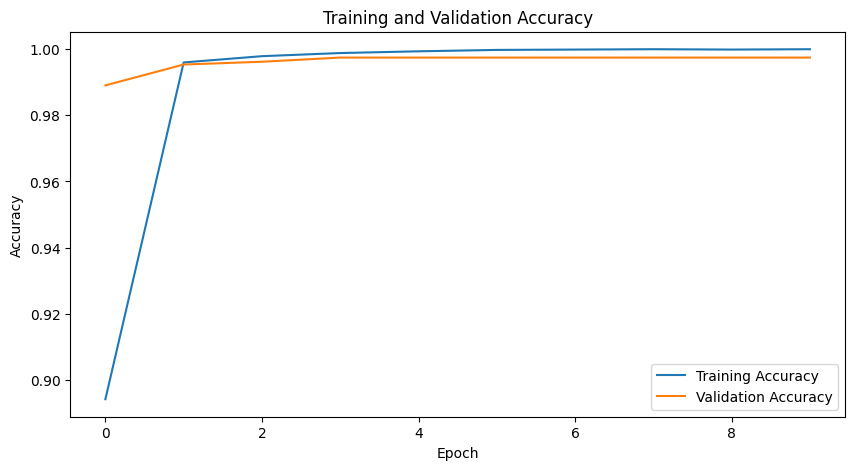

Epoch 1/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.66it/s]


train Loss: 1.7080 Acc: 0.9087


100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


val Loss: 0.0166 Acc: 0.9954
Saving Best Model with Validation Accuracy:  0.9953723180479597
Epoch 2/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.65it/s]


train Loss: 0.0111 Acc: 0.9972


100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


val Loss: 0.0129 Acc: 0.9958
Saving Best Model with Validation Accuracy:  0.995793016407236
Epoch 3/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.67it/s]


train Loss: 0.0073 Acc: 0.9985


100%|██████████| 38/38 [00:08<00:00,  4.36it/s]


val Loss: 0.0115 Acc: 0.9962
Saving Best Model with Validation Accuracy:  0.9962137147665124
Epoch 4/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.58it/s]


train Loss: 0.0055 Acc: 0.9988


100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


val Loss: 0.0112 Acc: 0.9962
Epoch 5/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.64it/s]


train Loss: 0.0041 Acc: 0.9997


100%|██████████| 38/38 [00:07<00:00,  5.33it/s]


val Loss: 0.0105 Acc: 0.9962
Epoch 6/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.72it/s]


train Loss: 0.0032 Acc: 0.9998


100%|██████████| 38/38 [00:08<00:00,  4.48it/s]


val Loss: 0.0095 Acc: 0.9962
Epoch 7/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.69it/s]


train Loss: 0.0027 Acc: 0.9999


100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


val Loss: 0.0092 Acc: 0.9971
Saving Best Model with Validation Accuracy:  0.9970551114850652
Epoch 8/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.58it/s]


train Loss: 0.0022 Acc: 1.0000


100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


val Loss: 0.0091 Acc: 0.9962
Epoch 9/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.73it/s]


train Loss: 0.0019 Acc: 1.0000


100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


val Loss: 0.0091 Acc: 0.9962
Epoch 10/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.90it/s]


train Loss: 0.0016 Acc: 1.0000


100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


val Loss: 0.0087 Acc: 0.9971
Training complete in 6m 37s
Best Validation Accuracy: 0.9971


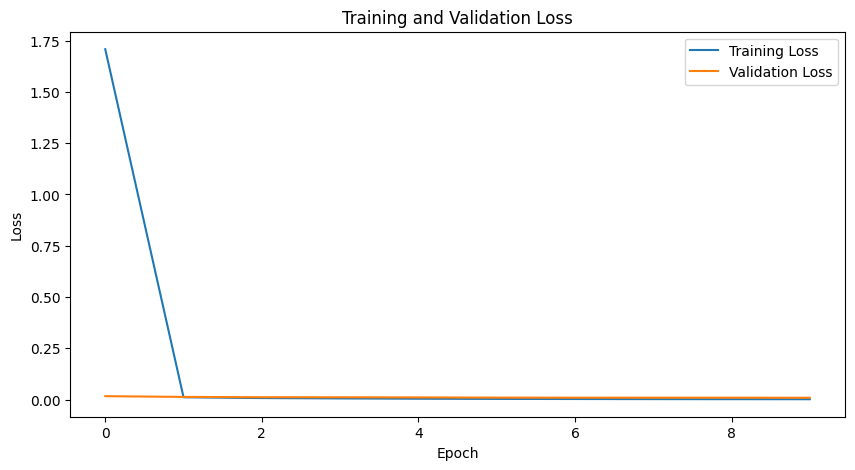

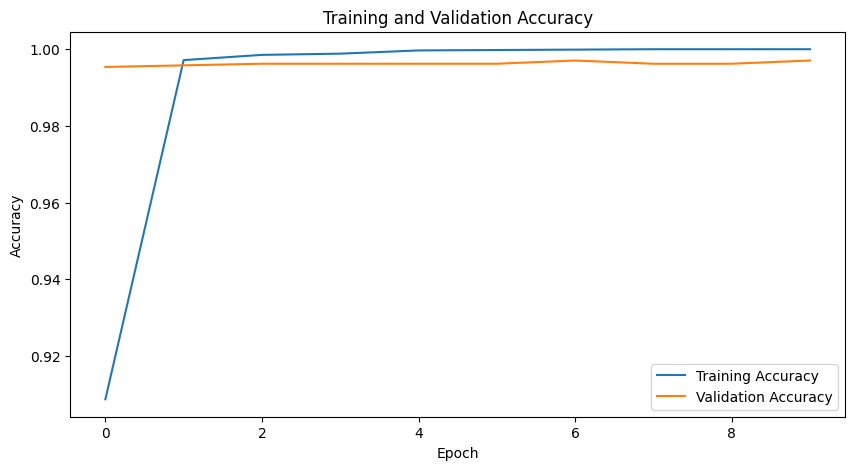

Epoch 1/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.67it/s]


train Loss: 1.6735 Acc: 0.8956


100%|██████████| 38/38 [00:08<00:00,  4.56it/s]


val Loss: 0.0191 Acc: 0.9937
Saving Best Model with Validation Accuracy:  0.993689524610854
Epoch 2/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.64it/s]


train Loss: 0.0123 Acc: 0.9958


100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


val Loss: 0.0135 Acc: 0.9971
Saving Best Model with Validation Accuracy:  0.9970551114850652
Epoch 3/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.69it/s]


train Loss: 0.0079 Acc: 0.9979


100%|██████████| 38/38 [00:08<00:00,  4.69it/s]


val Loss: 0.0121 Acc: 0.9958
Epoch 4/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.59it/s]


train Loss: 0.0056 Acc: 0.9987


100%|██████████| 38/38 [00:08<00:00,  4.42it/s]


val Loss: 0.0099 Acc: 0.9979
Saving Best Model with Validation Accuracy:  0.9978965082036181
Epoch 5/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.57it/s]


train Loss: 0.0041 Acc: 0.9995


100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


val Loss: 0.0093 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983172065628945
Epoch 6/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.53it/s]


train Loss: 0.0031 Acc: 0.9996


100%|██████████| 38/38 [00:07<00:00,  5.14it/s]


val Loss: 0.0101 Acc: 0.9979
Epoch 7/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.78it/s]


train Loss: 0.0026 Acc: 1.0000


100%|██████████| 38/38 [00:08<00:00,  4.62it/s]


val Loss: 0.0086 Acc: 0.9983
Epoch 8/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.88it/s]


train Loss: 0.0021 Acc: 1.0000


100%|██████████| 38/38 [00:07<00:00,  5.26it/s]


val Loss: 0.0084 Acc: 0.9983
Epoch 9/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.80it/s]


train Loss: 0.0018 Acc: 1.0000


100%|██████████| 38/38 [00:07<00:00,  4.81it/s]


val Loss: 0.0084 Acc: 0.9979
Epoch 10/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.93it/s]


train Loss: 0.0016 Acc: 1.0000


100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


val Loss: 0.0086 Acc: 0.9983
Training complete in 6m 35s
Best Validation Accuracy: 0.9983


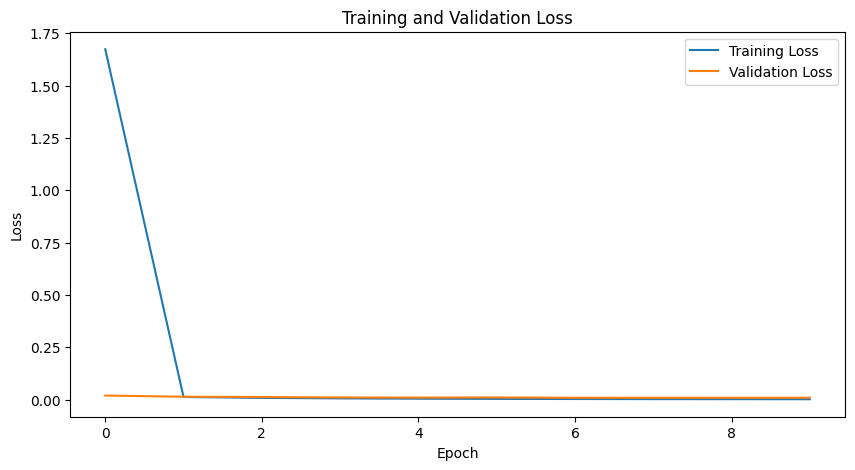

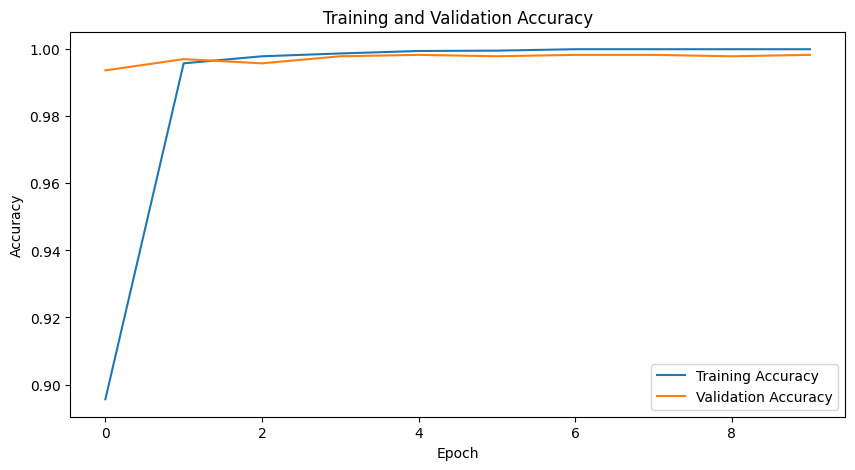

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_org_cl0_cl2_{seed}" + "train.pt"))

In [ ]:
#model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
#pid = datetime.now().strftime('%Y%m%d%H%M%S')
#torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_org_cl0_cl2_1" + "train.pt"))

### Background




In [ ]:
import os

def count_images(folder_path):
    return len([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Replace these paths with your actual folder paths on Google Drive
folder1 = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'
folder2 = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/train/class_0'
folder3 = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
folder4 = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'
folder5 = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/test/class_2'

# Count and print the number of images in each folder
count1 = count_images(folder1)
count2 = count_images(folder2)
count3 = count_images(folder3)
count4 = count_images(folder4)
count5 = count_images(folder5)

print(f"original/train/class_0_half '{folder1}': {count1}")
print(f"ackground/train/class_0 '{folder2}': {count2}")
print(f"original/train/class_2 '{folder3}': {count3}")
print(f"background/test/class_2 '{folder4}': {count4}")
print(f"background/test/class_0 '{folder5}': {count5}")


original/train/class_0_half '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half': 5923
ackground/train/class_0 '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/train/class_0': 5923
original/train/class_2 '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2': 5958
background/test/class_2 '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2': 1032
background/test/class_0 '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/test/class_2': 1032


In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2' #train
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half' #train
two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/train/class_2'
zero_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/train/class_0' #train

#Test
test_two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
dataset_two_bg = MnistDataset(path=two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(two_bg_path)))
dataset_zero_bg = MnistDataset(path=zero_bg_path, is_two=0, group_labels=[3] * len(os.listdir(zero_bg_path)))
dataset_test_two_bg = MnistDataset(path=test_two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_bg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_bg, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_bg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 14243
num_val: 3561
num_test: 1032


Epoch 1/10
----------


100%|██████████| 223/223 [59:45<00:00, 16.08s/it]


train Loss: 1.3810 Acc: 0.9461


100%|██████████| 56/56 [14:11<00:00, 15.20s/it]


val Loss: 0.0115 Acc: 0.9961
Saving Best Model with Validation Accuracy:  0.9960685200786296
Epoch 2/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.67it/s]


train Loss: 0.0093 Acc: 0.9977


100%|██████████| 56/56 [00:09<00:00,  5.72it/s]


val Loss: 0.0103 Acc: 0.9961
Epoch 3/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.70it/s]


train Loss: 0.0053 Acc: 0.9989


100%|██████████| 56/56 [00:09<00:00,  5.76it/s]


val Loss: 0.0077 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974726200505476
Epoch 4/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.66it/s]


train Loss: 0.0036 Acc: 0.9996


100%|██████████| 56/56 [00:09<00:00,  5.86it/s]


val Loss: 0.0068 Acc: 0.9975
Epoch 5/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.71it/s]


train Loss: 0.0027 Acc: 0.9998


100%|██████████| 56/56 [00:10<00:00,  5.51it/s]


val Loss: 0.0066 Acc: 0.9975
Epoch 6/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.72it/s]


train Loss: 0.0023 Acc: 0.9999


100%|██████████| 56/56 [00:09<00:00,  5.81it/s]


val Loss: 0.0061 Acc: 0.9978
Saving Best Model with Validation Accuracy:  0.9977534400449312
Epoch 7/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.69it/s]


train Loss: 0.0017 Acc: 0.9999


100%|██████████| 56/56 [00:09<00:00,  5.78it/s]


val Loss: 0.0059 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.9980342600393148
Epoch 8/10
----------


100%|██████████| 223/223 [00:38<00:00,  5.75it/s]


train Loss: 0.0014 Acc: 0.9999


100%|██████████| 56/56 [00:09<00:00,  5.69it/s]


val Loss: 0.0056 Acc: 0.9978
Epoch 9/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.68it/s]


train Loss: 0.0012 Acc: 1.0000


100%|██████████| 56/56 [00:09<00:00,  5.86it/s]


val Loss: 0.0055 Acc: 0.9980
Epoch 10/10
----------


100%|██████████| 223/223 [00:38<00:00,  5.72it/s]


train Loss: 0.0010 Acc: 1.0000


100%|██████████| 56/56 [00:09<00:00,  5.79it/s]


val Loss: 0.0053 Acc: 0.9980
Training complete in 81m 16s
Best Validation Accuracy: 0.9980


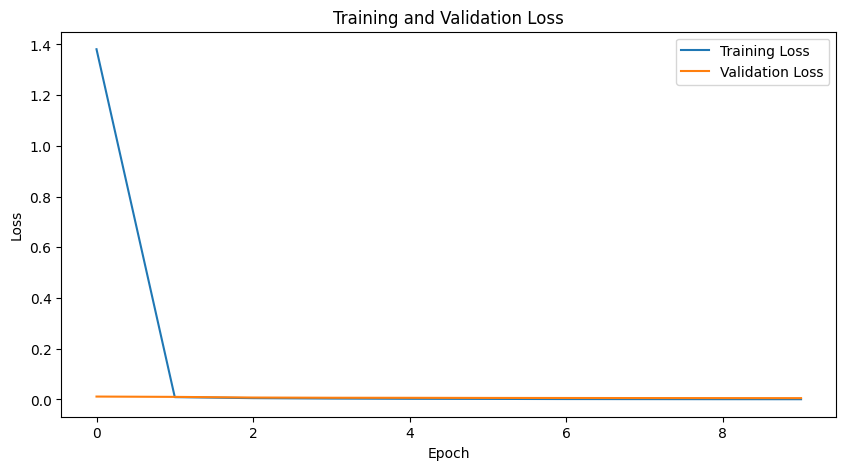

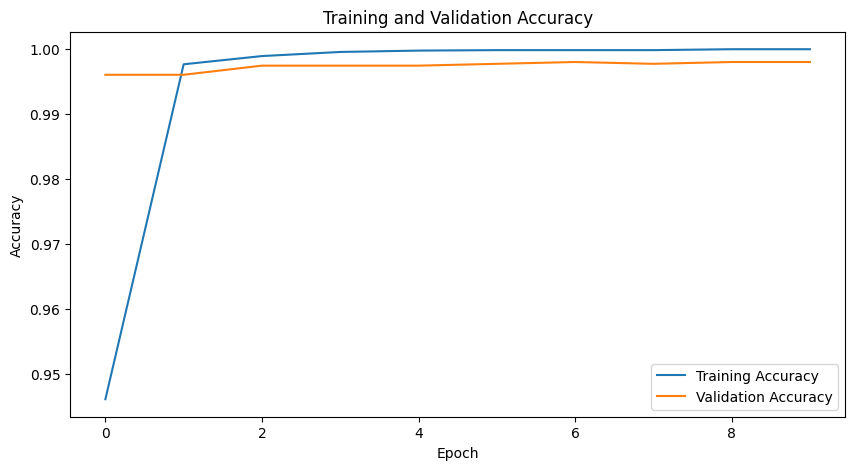

Epoch 1/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.59it/s]


train Loss: 0.4549 Acc: 0.9723


100%|██████████| 56/56 [00:09<00:00,  5.60it/s]


val Loss: 0.0077 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.9980342600393148
Epoch 2/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.65it/s]


train Loss: 0.0052 Acc: 0.9981


100%|██████████| 56/56 [00:09<00:00,  5.76it/s]


val Loss: 0.0051 Acc: 0.9980
Epoch 3/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.70it/s]


train Loss: 0.0030 Acc: 0.9994


100%|██████████| 56/56 [00:09<00:00,  5.81it/s]


val Loss: 0.0068 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983150800336984
Epoch 4/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.69it/s]


train Loss: 0.0017 Acc: 0.9996


100%|██████████| 56/56 [00:09<00:00,  5.62it/s]


val Loss: 0.0056 Acc: 0.9983
Epoch 5/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.71it/s]


train Loss: 0.0019 Acc: 0.9998


100%|██████████| 56/56 [00:09<00:00,  5.68it/s]


val Loss: 0.0060 Acc: 0.9980
Epoch 6/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.68it/s]


train Loss: 0.0011 Acc: 0.9999


100%|██████████| 56/56 [00:09<00:00,  5.74it/s]


val Loss: 0.0043 Acc: 0.9986
Saving Best Model with Validation Accuracy:  0.998595900028082
Epoch 7/10
----------


100%|██████████| 223/223 [00:38<00:00,  5.73it/s]


train Loss: 0.0007 Acc: 1.0000


100%|██████████| 56/56 [00:09<00:00,  5.77it/s]


val Loss: 0.0043 Acc: 0.9989
Saving Best Model with Validation Accuracy:  0.9988767200224656
Epoch 8/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.60it/s]


train Loss: 0.0006 Acc: 1.0000


100%|██████████| 56/56 [00:09<00:00,  5.81it/s]


val Loss: 0.0042 Acc: 0.9986
Epoch 9/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.70it/s]


train Loss: 0.0004 Acc: 1.0000


100%|██████████| 56/56 [00:09<00:00,  5.73it/s]


val Loss: 0.0042 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991575400168492
Epoch 10/10
----------


100%|██████████| 223/223 [00:38<00:00,  5.76it/s]


train Loss: 0.0004 Acc: 1.0000


100%|██████████| 56/56 [00:09<00:00,  5.71it/s]


val Loss: 0.0041 Acc: 0.9989
Training complete in 8m 11s
Best Validation Accuracy: 0.9992


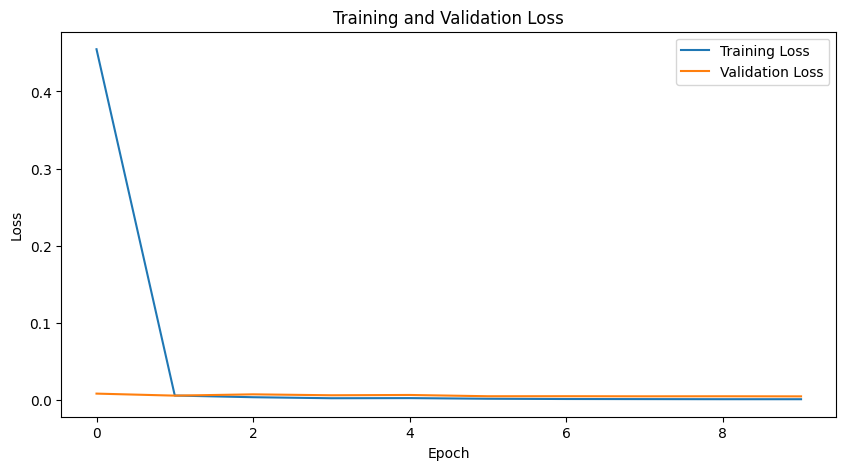

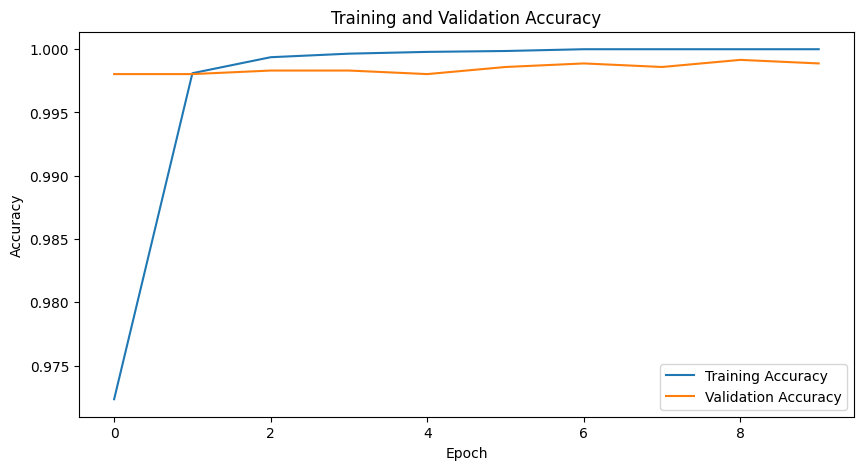

Epoch 1/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.59it/s]


train Loss: 0.8627 Acc: 0.9527


100%|██████████| 56/56 [00:09<00:00,  5.77it/s]


val Loss: 0.0074 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966301600673968
Epoch 2/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.63it/s]


train Loss: 0.0068 Acc: 0.9978


100%|██████████| 56/56 [00:09<00:00,  5.63it/s]


val Loss: 0.0062 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.9980342600393148
Epoch 3/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.68it/s]


train Loss: 0.0044 Acc: 0.9990


100%|██████████| 56/56 [00:09<00:00,  5.71it/s]


val Loss: 0.0063 Acc: 0.9975
Epoch 4/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.61it/s]


train Loss: 0.0031 Acc: 0.9995


100%|██████████| 56/56 [00:09<00:00,  5.87it/s]


val Loss: 0.0042 Acc: 0.9989
Saving Best Model with Validation Accuracy:  0.9988767200224656
Epoch 5/10
----------


100%|██████████| 223/223 [00:38<00:00,  5.72it/s]


train Loss: 0.0024 Acc: 0.9996


100%|██████████| 56/56 [00:09<00:00,  5.63it/s]


val Loss: 0.0039 Acc: 0.9989
Epoch 6/10
----------


100%|██████████| 223/223 [00:38<00:00,  5.75it/s]


train Loss: 0.0018 Acc: 0.9999


100%|██████████| 56/56 [00:09<00:00,  5.81it/s]


val Loss: 0.0037 Acc: 0.9989
Epoch 7/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.66it/s]


train Loss: 0.0015 Acc: 0.9999


100%|██████████| 56/56 [00:09<00:00,  5.80it/s]


val Loss: 0.0034 Acc: 0.9989
Epoch 8/10
----------


100%|██████████| 223/223 [00:39<00:00,  5.72it/s]


train Loss: 0.0012 Acc: 0.9999


100%|██████████| 56/56 [00:09<00:00,  5.66it/s]


val Loss: 0.0037 Acc: 0.9989
Epoch 9/10
----------


100%|██████████| 223/223 [00:38<00:00,  5.73it/s]


train Loss: 0.0011 Acc: 0.9999


100%|██████████| 56/56 [00:09<00:00,  5.80it/s]


val Loss: 0.0035 Acc: 0.9986
Epoch 10/10
----------


100%|██████████| 223/223 [00:38<00:00,  5.73it/s]


train Loss: 0.0009 Acc: 0.9999


100%|██████████| 56/56 [00:10<00:00,  5.48it/s]


val Loss: 0.0033 Acc: 0.9989
Training complete in 8m 11s
Best Validation Accuracy: 0.9989


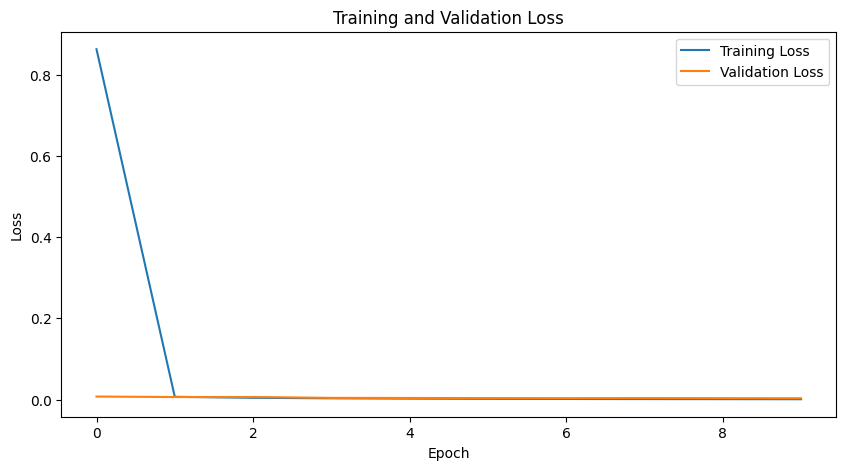

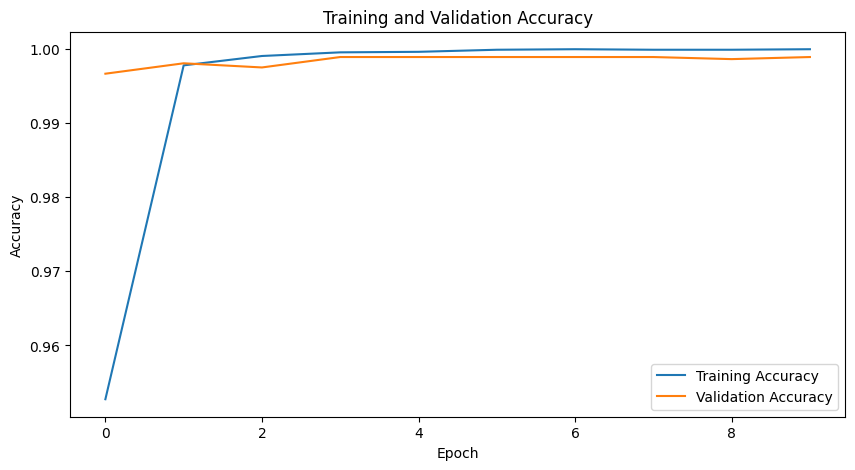

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_bg_cl0_cl2_{seed}" + "train.pt"))

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime

# Function to load the trained model
def load_model(model_path, device):
    model = AlexNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:  # Ignore group_label
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy


# Define paths to the test datasets
test_two_bg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'
test_two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

# Create test datasets
dataset_test_two_bg = MnistDataset(path=test_two_bg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_bg_path)))
dataset_test_two_org = MnistDataset(path=test_two_org_path, is_two=1, group_labels=[0] * len(os.listdir(test_two_org_path)))

# Create dataloaders for the test datasets
batch_size = 64
test_loader_bg = DataLoader(dataset_test_two_bg, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_org = DataLoader(dataset_test_two_org, batch_size=batch_size, shuffle=False, num_workers=2)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and test the model for each seed
seeds = [1, 11, 111]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_bg_cl0_cl2_{seed}train.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on background dataset
    accuracy_bg = test_model(model, test_loader_bg, device)
    print(f"Accuracy on background test dataset (class_2): {accuracy_bg:.2f}%")

    # Test on original dataset
    accuracy_org = test_model(model, test_loader_org, device)
    print(f"Accuracy on original test dataset (class_2): {accuracy_org:.2f}%")



Loading model with seed 1


<ipython-input-15-202c575b7126>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Accuracy on background test dataset (class_2): 0.00%
Accuracy on original test dataset (class_2): 99.71%

Loading model with seed 11
Accuracy on background test dataset (class_2): 0.00%
Accuracy on original test dataset (class_2): 99.81%

Loading model with seed 111
Accuracy on background test dataset (class_2): 0.00%
Accuracy on original test dataset (class_2): 99.81%


### Foreground

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half' #first half
two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/train/class_2'
zero_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/train/class_0_half' #second half

#Test
test_two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
dataset_two_fg = MnistDataset(path=two_fg_path, is_two=1, group_labels=[1] * len(os.listdir(two_fg_path)))
dataset_zero_fg = MnistDataset(path=zero_fg_path, is_two=0, group_labels=[3] * len(os.listdir(zero_fg_path)))
dataset_test_two_fg = MnistDataset(path=test_two_fg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_fg_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_fg, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_fg

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 11873
num_val: 2969
num_test: 1032


Epoch 1/10
----------


100%|██████████| 186/186 [15:21<00:00,  4.95s/it]


train Loss: 1.4084 Acc: 0.9303


100%|██████████| 47/47 [03:40<00:00,  4.70s/it]


val Loss: 0.0181 Acc: 0.9933
Saving Best Model with Validation Accuracy:  0.9932637251599865
Epoch 2/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.83it/s]


train Loss: 0.0124 Acc: 0.9970


100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


val Loss: 0.0131 Acc: 0.9963
Saving Best Model with Validation Accuracy:  0.9962950488379926
Epoch 3/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.79it/s]


train Loss: 0.0076 Acc: 0.9981


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


val Loss: 0.0094 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 4/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.76it/s]


train Loss: 0.0056 Acc: 0.9986


100%|██████████| 47/47 [00:09<00:00,  5.19it/s]


val Loss: 0.0117 Acc: 0.9960
Epoch 5/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.68it/s]


train Loss: 0.0042 Acc: 0.9992


100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


val Loss: 0.0063 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 6/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.91it/s]


train Loss: 0.0032 Acc: 0.9995


100%|██████████| 47/47 [00:10<00:00,  4.64it/s]


val Loss: 0.0057 Acc: 0.9993
Saving Best Model with Validation Accuracy:  0.9993263725159987
Epoch 7/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.59it/s]


train Loss: 0.0026 Acc: 0.9997


100%|██████████| 47/47 [00:08<00:00,  5.24it/s]


val Loss: 0.0052 Acc: 0.9990
Epoch 8/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.75it/s]


train Loss: 0.0021 Acc: 0.9998


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


val Loss: 0.0052 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.76it/s]


train Loss: 0.0018 Acc: 0.9999


100%|██████████| 47/47 [00:10<00:00,  4.68it/s]


val Loss: 0.0045 Acc: 0.9990
Epoch 10/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.82it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  5.11it/s]


val Loss: 0.0045 Acc: 0.9987
Training complete in 26m 20s
Best Validation Accuracy: 0.9993


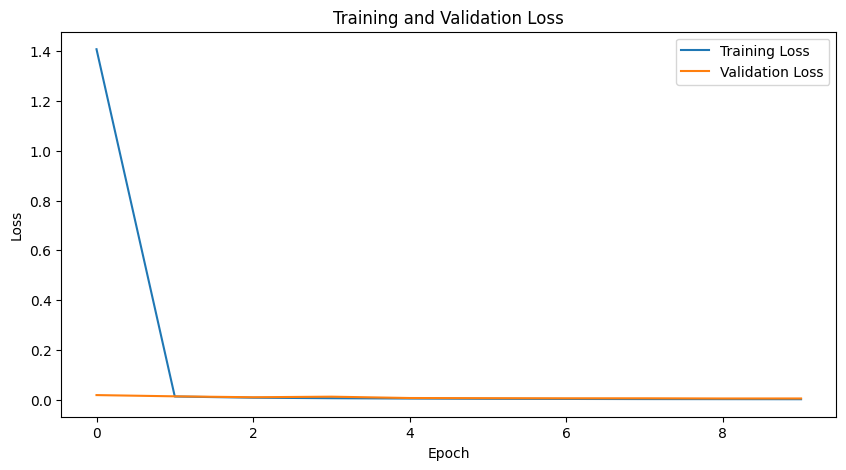

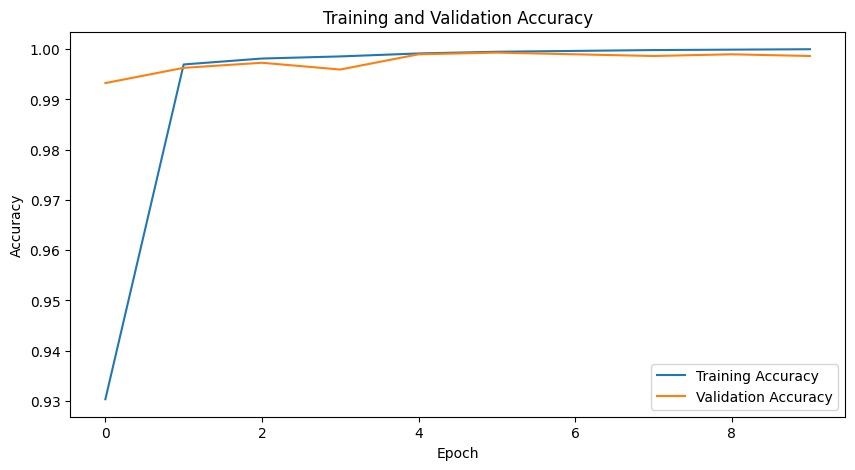

Epoch 1/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.73it/s]


train Loss: 0.7262 Acc: 0.9565


100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


val Loss: 0.0086 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 2/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.99it/s]


train Loss: 0.0063 Acc: 0.9980


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


val Loss: 0.0065 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983159312899966
Epoch 3/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.73it/s]


train Loss: 0.0039 Acc: 0.9986


100%|██████████| 47/47 [00:09<00:00,  4.98it/s]


val Loss: 0.0061 Acc: 0.9983
Epoch 4/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.81it/s]


train Loss: 0.0020 Acc: 0.9997


100%|██████████| 47/47 [00:08<00:00,  5.61it/s]


val Loss: 0.0056 Acc: 0.9983
Epoch 5/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.83it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  5.07it/s]


val Loss: 0.0048 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 6/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.12it/s]


train Loss: 0.0012 Acc: 0.9999


100%|██████████| 47/47 [00:09<00:00,  4.97it/s]


val Loss: 0.0046 Acc: 0.9990
Epoch 7/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.72it/s]


train Loss: 0.0010 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


val Loss: 0.0044 Acc: 0.9990
Epoch 8/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.88it/s]


train Loss: 0.0008 Acc: 1.0000


100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


val Loss: 0.0046 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.91it/s]


train Loss: 0.0007 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


val Loss: 0.0044 Acc: 0.9990
Epoch 10/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.70it/s]


train Loss: 0.0006 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  5.18it/s]


val Loss: 0.0042 Acc: 0.9990
Training complete in 7m 60s
Best Validation Accuracy: 0.9990


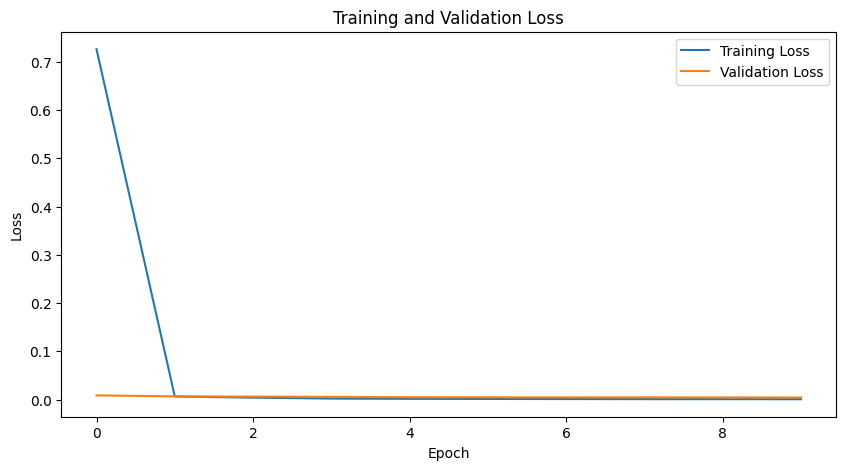

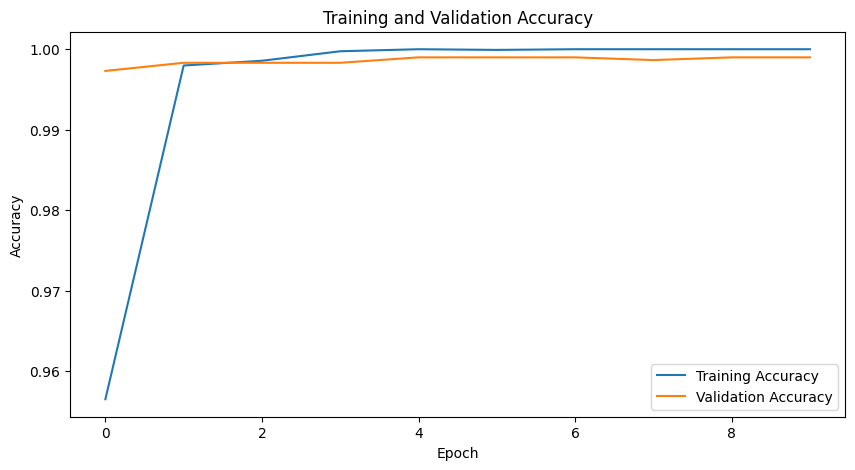

Epoch 1/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.75it/s]


train Loss: 0.4905 Acc: 0.9596


100%|██████████| 47/47 [00:08<00:00,  5.57it/s]


val Loss: 0.0135 Acc: 0.9949
Saving Best Model with Validation Accuracy:  0.9949477938699899
Epoch 2/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.82it/s]


train Loss: 0.0143 Acc: 0.9963


100%|██████████| 47/47 [00:08<00:00,  5.35it/s]


val Loss: 0.0035 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983159312899966
Epoch 3/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.88it/s]


train Loss: 0.0038 Acc: 0.9982


100%|██████████| 47/47 [00:09<00:00,  4.70it/s]


val Loss: 0.0039 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 4/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.98it/s]


train Loss: 0.0045 Acc: 0.9984


100%|██████████| 47/47 [00:10<00:00,  4.40it/s]


val Loss: 0.0044 Acc: 0.9983
Epoch 5/10
----------


100%|██████████| 186/186 [00:41<00:00,  4.53it/s]


train Loss: 0.0020 Acc: 0.9992


100%|██████████| 47/47 [00:09<00:00,  4.89it/s]


val Loss: 0.0053 Acc: 0.9980
Epoch 6/10
----------


100%|██████████| 186/186 [00:41<00:00,  4.50it/s]


train Loss: 0.0005 Acc: 0.9999


100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


val Loss: 0.0055 Acc: 0.9980
Epoch 7/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.59it/s]


train Loss: 0.0003 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  4.77it/s]


val Loss: 0.0023 Acc: 0.9993
Saving Best Model with Validation Accuracy:  0.9993263725159987
Epoch 8/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.59it/s]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


val Loss: 0.0020 Acc: 0.9987
Epoch 9/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.63it/s]


train Loss: 0.0003 Acc: 0.9999


100%|██████████| 47/47 [00:10<00:00,  4.60it/s]


val Loss: 0.0022 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.78it/s]


train Loss: 0.0002 Acc: 1.0000


100%|██████████| 47/47 [00:08<00:00,  5.48it/s]


val Loss: 0.0022 Acc: 0.9993
Training complete in 8m 13s
Best Validation Accuracy: 0.9993


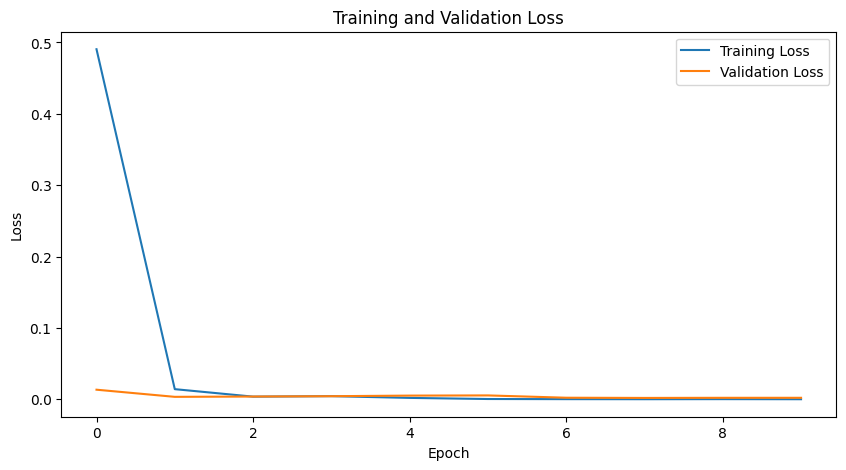

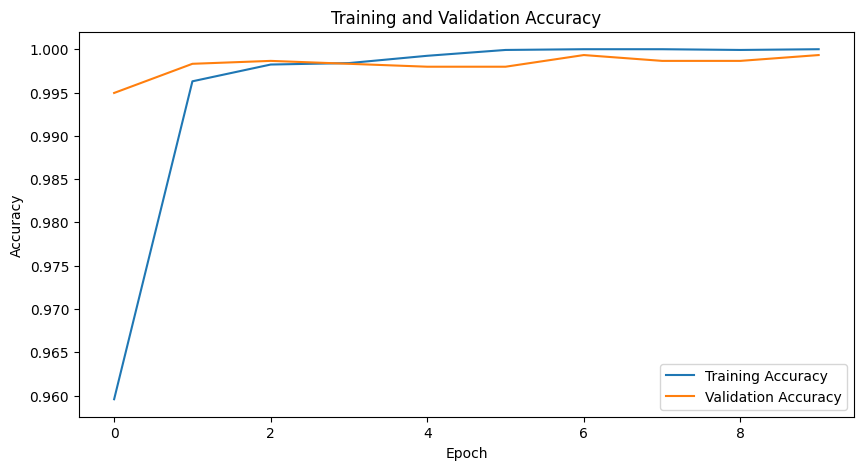

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_fg_cl0_cl2_{seed}" + "train.pt"))

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime

# Function to load the trained model
def load_model(model_path, device):
    print(f"Loading model from {model_path}")
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    print("Model loaded and layers frozen successfully")
    return model


# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:  # Ignore group_label
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy


# Define paths to the test datasets
test_two_fg_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'
test_two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

# Create test datasets
dataset_test_two_fg = MnistDataset(path=test_two_fg_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_fg_path)))
dataset_test_two_org = MnistDataset(path=test_two_org_path, is_two=1, group_labels=[0] * len(os.listdir(test_two_org_path)))

# Create dataloaders for the test datasets
batch_size = 64
test_loader_fg = DataLoader(dataset_test_two_fg, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_org = DataLoader(dataset_test_two_org, batch_size=batch_size, shuffle=False, num_workers=2)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and test the model for each seed
seeds = [1, 11, 111]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_{seed}train.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on foreground dataset
    accuracy_fg = test_model(model, test_loader_fg, device)
    print(f"Accuracy on foreground test dataset (class_2): {accuracy_fg:.2f}%")

    # Test on original dataset
    accuracy_org = test_model(model, test_loader_org, device)
    print(f"Accuracy on original test dataset (class_2): {accuracy_org:.2f}%")



Loading model with seed 1
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_1train.pt


<ipython-input-11-93e56babed3d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded and layers frozen successfully
Accuracy on foreground test dataset (class_2): 0.00%
Accuracy on original test dataset (class_2): 99.52%

Loading model with seed 11
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_11train.pt
Model loaded and layers frozen successfully
Accuracy on foreground test dataset (class_2): 0.00%
Accuracy on original test dataset (class_2): 99.81%

Loading model with seed 111
Loading model from /content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_111train.pt
Model loaded and layers frozen successfully
Accuracy on foreground test dataset (class_2): 0.00%
Accuracy on original test dataset (class_2): 99.71%


### Left patch

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'
two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2'
zero_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_0_half'

#Test
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
dataset_two_lp = MnistDataset(path=two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(two_lp_path)))
dataset_zero_lp = MnistDataset(path=zero_lp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_lp_path)))
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_lp, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_lp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 11873
num_val: 2969
num_test: 1032


Epoch 1/10
----------


100%|██████████| 186/186 [15:29<00:00,  5.00s/it]


train Loss: 0.7804 Acc: 0.9608


100%|██████████| 47/47 [03:40<00:00,  4.70s/it]


val Loss: 0.0132 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 2/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.08it/s]


train Loss: 0.0108 Acc: 0.9966


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


val Loss: 0.0051 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983159312899966
Epoch 3/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.89it/s]


train Loss: 0.0053 Acc: 0.9984


100%|██████████| 47/47 [00:09<00:00,  5.00it/s]


val Loss: 0.0083 Acc: 0.9963
Epoch 4/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.84it/s]


train Loss: 0.0039 Acc: 0.9992


100%|██████████| 47/47 [00:08<00:00,  5.29it/s]


val Loss: 0.0040 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 5/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.77it/s]


train Loss: 0.0023 Acc: 0.9997


100%|██████████| 47/47 [00:09<00:00,  4.74it/s]


val Loss: 0.0043 Acc: 0.9987
Epoch 6/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.88it/s]


train Loss: 0.0016 Acc: 0.9997


100%|██████████| 47/47 [00:09<00:00,  4.84it/s]


val Loss: 0.0037 Acc: 0.9987
Epoch 7/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.90it/s]


train Loss: 0.0013 Acc: 0.9999


100%|██████████| 47/47 [00:08<00:00,  5.46it/s]


val Loss: 0.0032 Acc: 0.9993
Saving Best Model with Validation Accuracy:  0.9993263725159987
Epoch 8/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.83it/s]


train Loss: 0.0010 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  5.01it/s]


val Loss: 0.0035 Acc: 0.9993
Epoch 9/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.81it/s]


train Loss: 0.0011 Acc: 1.0000


100%|██████████| 47/47 [00:10<00:00,  4.59it/s]


val Loss: 0.0032 Acc: 0.9993
Epoch 10/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.76it/s]


train Loss: 0.0007 Acc: 1.0000


100%|██████████| 47/47 [00:10<00:00,  4.65it/s]


val Loss: 0.0029 Acc: 0.9993
Training complete in 26m 21s
Best Validation Accuracy: 0.9993


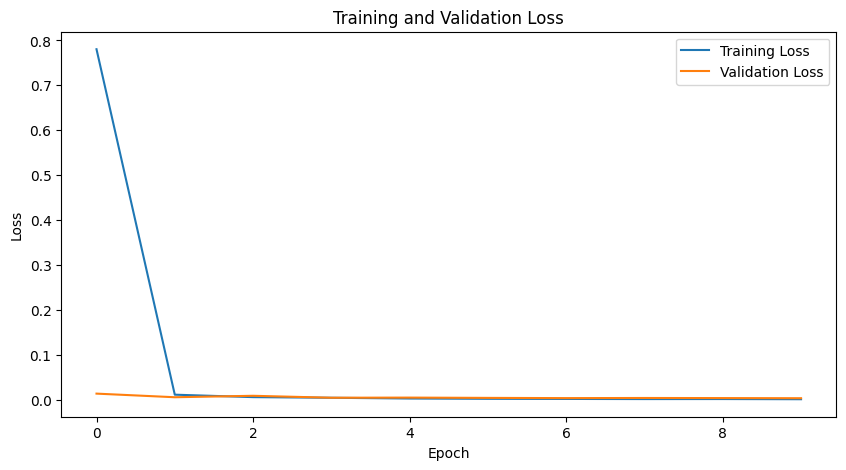

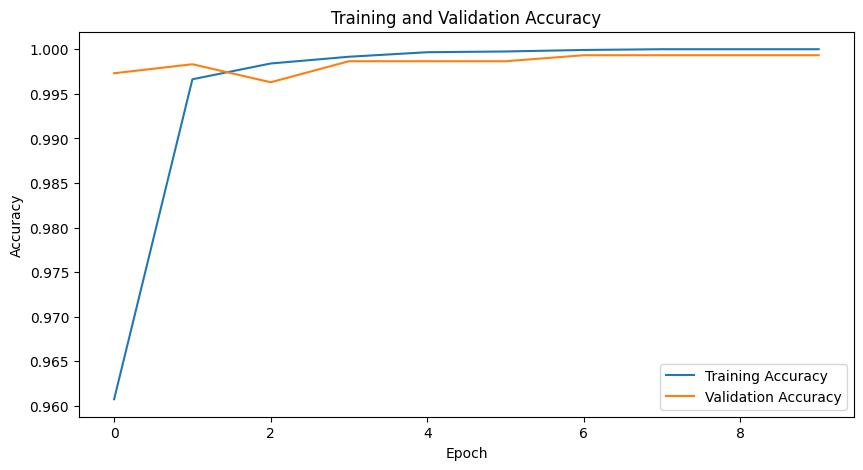

Epoch 1/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.57it/s]


train Loss: 1.3981 Acc: 0.9234


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


val Loss: 0.0155 Acc: 0.9956
Saving Best Model with Validation Accuracy:  0.9956214213539912
Epoch 2/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.97it/s]


train Loss: 0.0112 Acc: 0.9970


100%|██████████| 47/47 [00:09<00:00,  4.82it/s]


val Loss: 0.0097 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 3/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.99it/s]


train Loss: 0.0068 Acc: 0.9985


100%|██████████| 47/47 [00:09<00:00,  4.71it/s]


val Loss: 0.0083 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.997979117547996
Epoch 4/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.77it/s]


train Loss: 0.0048 Acc: 0.9990


100%|██████████| 47/47 [00:08<00:00,  5.41it/s]


val Loss: 0.0062 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983159312899966
Epoch 5/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.85it/s]


train Loss: 0.0034 Acc: 0.9996


100%|██████████| 47/47 [00:09<00:00,  5.06it/s]


val Loss: 0.0052 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 6/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.85it/s]


train Loss: 0.0028 Acc: 0.9997


100%|██████████| 47/47 [00:09<00:00,  4.84it/s]


val Loss: 0.0047 Acc: 0.9983
Epoch 7/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.05it/s]


train Loss: 0.0022 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


val Loss: 0.0041 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.94it/s]


train Loss: 0.0017 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  4.99it/s]


val Loss: 0.0039 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 9/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.86it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  5.18it/s]


val Loss: 0.0036 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.83it/s]


train Loss: 0.0013 Acc: 1.0000


100%|██████████| 47/47 [00:08<00:00,  5.23it/s]


val Loss: 0.0033 Acc: 0.9987
Training complete in 7m 57s
Best Validation Accuracy: 0.9990


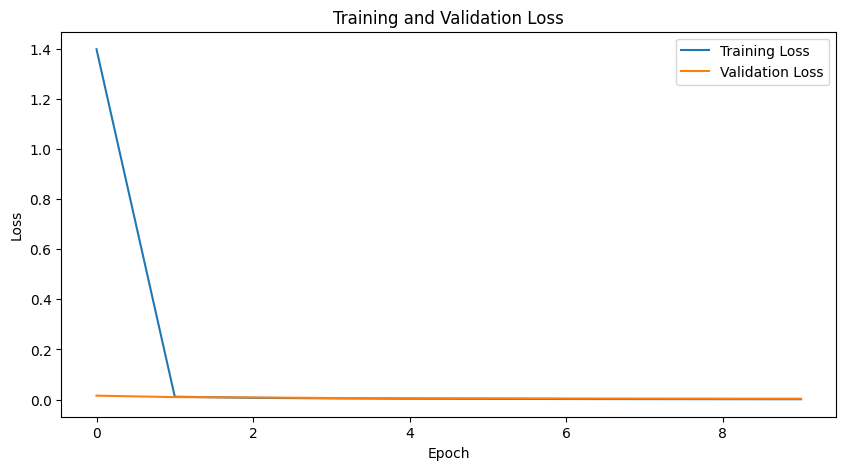

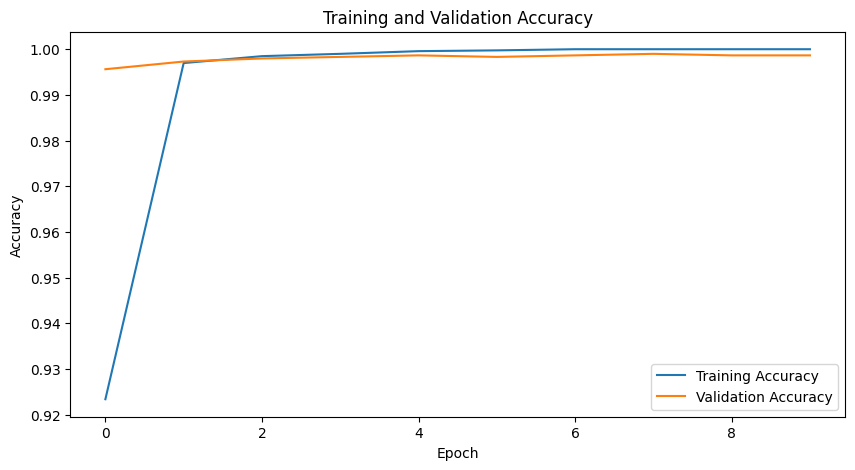

Epoch 1/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.92it/s]


train Loss: 1.0624 Acc: 0.9352


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


val Loss: 0.0101 Acc: 0.9970
Saving Best Model with Validation Accuracy:  0.9969686763219939
Epoch 2/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.87it/s]


train Loss: 0.0082 Acc: 0.9977


100%|██████████| 47/47 [00:09<00:00,  5.00it/s]


val Loss: 0.0070 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 3/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.89it/s]


train Loss: 0.0052 Acc: 0.9991


100%|██████████| 47/47 [00:08<00:00,  5.65it/s]


val Loss: 0.0056 Acc: 0.9976
Saving Best Model with Validation Accuracy:  0.9976423038059953
Epoch 4/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.86it/s]


train Loss: 0.0037 Acc: 0.9992


100%|██████████| 47/47 [00:09<00:00,  5.19it/s]


val Loss: 0.0052 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.997979117547996
Epoch 5/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.91it/s]


train Loss: 0.0028 Acc: 0.9995


100%|██████████| 47/47 [00:09<00:00,  4.93it/s]


val Loss: 0.0049 Acc: 0.9980
Epoch 6/10
----------


100%|██████████| 186/186 [00:36<00:00,  5.05it/s]


train Loss: 0.0022 Acc: 0.9998


100%|██████████| 47/47 [00:09<00:00,  4.72it/s]


val Loss: 0.0034 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 7/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.89it/s]


train Loss: 0.0017 Acc: 0.9998


100%|██████████| 47/47 [00:09<00:00,  4.86it/s]


val Loss: 0.0034 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.78it/s]


train Loss: 0.0014 Acc: 0.9998


100%|██████████| 47/47 [00:08<00:00,  5.28it/s]


val Loss: 0.0030 Acc: 0.9990
Epoch 9/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.70it/s]


train Loss: 0.0012 Acc: 0.9998


100%|██████████| 47/47 [00:09<00:00,  4.84it/s]


val Loss: 0.0027 Acc: 0.9990
Epoch 10/10
----------


100%|██████████| 186/186 [00:37<00:00,  5.00it/s]


train Loss: 0.0010 Acc: 0.9999


100%|██████████| 47/47 [00:09<00:00,  4.79it/s]


val Loss: 0.0027 Acc: 0.9990
Training complete in 7m 55s
Best Validation Accuracy: 0.9990


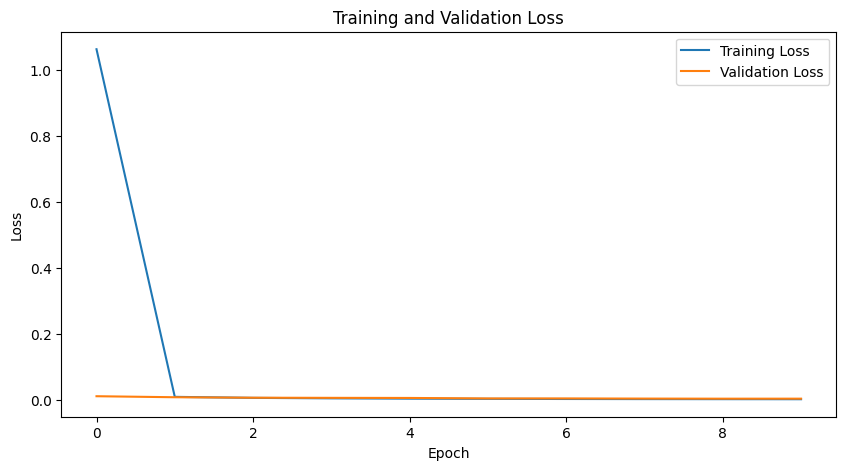

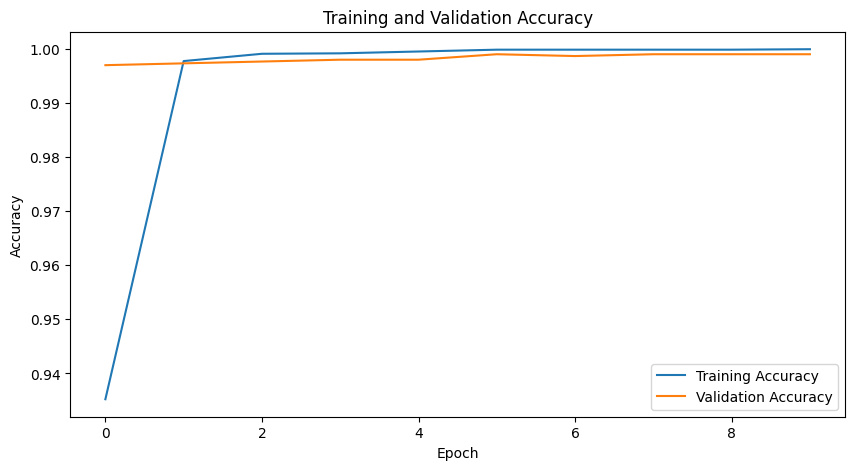

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_lp_cl0_cl2_{seed}" + "train.pt"))

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime

# Function to load the trained model
def load_model(model_path, device):
    model = AlexNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:  # Ignore group_label
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy


# Define paths to the test datasets
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
test_two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

# Create test datasets
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))
dataset_test_two_org = MnistDataset(path=test_two_org_path, is_two=1, group_labels=[0] * len(os.listdir(test_two_org_path)))

# Create dataloaders for the test datasets
batch_size = 64
test_loader_lp = DataLoader(dataset_test_two_lp, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_org = DataLoader(dataset_test_two_org, batch_size=batch_size, shuffle=False, num_workers=2)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and test the model for each seed
seeds = [1, 11, 111]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_{seed}train.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on patches_left dataset
    accuracy_lp = test_model(model, test_loader_lp, device)
    print(f"Accuracy on patches_left test dataset (class_2): {accuracy_lp:.2f}%")

    # Test on original dataset
    accuracy_org = test_model(model, test_loader_org, device)
    print(f"Accuracy on original test dataset (class_2): {accuracy_org:.2f}%")



Loading model with seed 1


<ipython-input-9-13f88bcd894b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Accuracy on patches_left test dataset (class_2): 98.16%
Accuracy on original test dataset (class_2): 99.32%

Loading model with seed 11
Accuracy on patches_left test dataset (class_2): 98.64%
Accuracy on original test dataset (class_2): 99.52%

Loading model with seed 111
Accuracy on patches_left test dataset (class_2): 99.42%
Accuracy on original test dataset (class_2): 99.61%


### Center Patch

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half' #first half
two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2'
zero_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_0_half' #second half

#Test
test_two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
dataset_two_cp = MnistDataset(path=two_cp_path, is_two=1, group_labels=[1] * len(os.listdir(two_cp_path)))
dataset_zero_cp = MnistDataset(path=zero_cp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_cp_path)))
dataset_test_two_cp = MnistDataset(path=test_two_cp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_cp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_cp, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_cp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 11873
num_val: 2969
num_test: 1032


Epoch 1/10
----------


100%|██████████| 186/186 [01:47<00:00,  1.73it/s]


train Loss: 1.1173 Acc: 0.9292


100%|██████████| 47/47 [00:10<00:00,  4.67it/s]


val Loss: 0.0116 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 2/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.82it/s]


train Loss: 0.0092 Acc: 0.9972


100%|██████████| 47/47 [00:09<00:00,  4.83it/s]


val Loss: 0.0085 Acc: 0.9973
Epoch 3/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.66it/s]


train Loss: 0.0053 Acc: 0.9986


100%|██████████| 47/47 [00:08<00:00,  5.53it/s]


val Loss: 0.0068 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.997979117547996
Epoch 4/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.79it/s]


train Loss: 0.0038 Acc: 0.9992


100%|██████████| 47/47 [00:08<00:00,  5.23it/s]


val Loss: 0.0084 Acc: 0.9973
Epoch 5/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.89it/s]


train Loss: 0.0029 Acc: 0.9995


100%|██████████| 47/47 [00:09<00:00,  4.78it/s]


val Loss: 0.0054 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 6/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.79it/s]


train Loss: 0.0021 Acc: 0.9997


100%|██████████| 47/47 [00:10<00:00,  4.59it/s]


val Loss: 0.0050 Acc: 0.9987
Epoch 7/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.76it/s]


train Loss: 0.0017 Acc: 0.9999


100%|██████████| 47/47 [00:09<00:00,  5.05it/s]


val Loss: 0.0047 Acc: 0.9990
Epoch 8/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.72it/s]


train Loss: 0.0014 Acc: 1.0000


100%|██████████| 47/47 [00:08<00:00,  5.44it/s]


val Loss: 0.0046 Acc: 0.9990
Epoch 9/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.65it/s]


train Loss: 0.0012 Acc: 1.0000


100%|██████████| 47/47 [00:10<00:00,  4.54it/s]


val Loss: 0.0043 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.75it/s]


train Loss: 0.0010 Acc: 1.0000


100%|██████████| 47/47 [00:10<00:00,  4.59it/s]


val Loss: 0.0043 Acc: 0.9990
Training complete in 9m 16s
Best Validation Accuracy: 0.9990


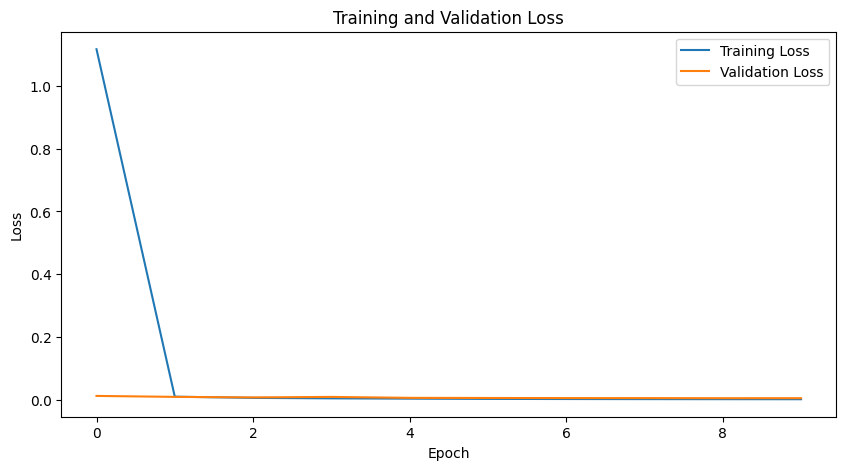

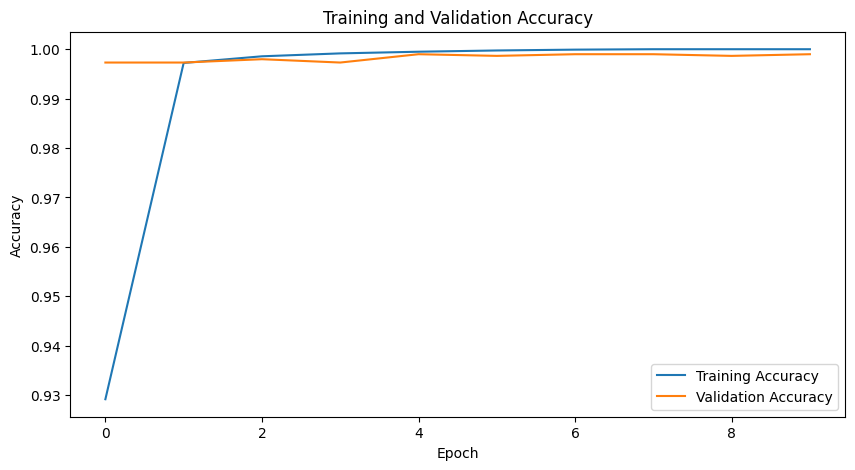

Epoch 1/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.62it/s]


train Loss: 1.4235 Acc: 0.9207


100%|██████████| 47/47 [00:10<00:00,  4.61it/s]


val Loss: 0.0146 Acc: 0.9970
Saving Best Model with Validation Accuracy:  0.9969686763219939
Epoch 2/10
----------


100%|██████████| 186/186 [00:41<00:00,  4.51it/s]


train Loss: 0.0111 Acc: 0.9972


100%|██████████| 47/47 [00:09<00:00,  5.01it/s]


val Loss: 0.0100 Acc: 0.9970
Epoch 3/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.73it/s]


train Loss: 0.0068 Acc: 0.9986


100%|██████████| 47/47 [00:10<00:00,  4.60it/s]


val Loss: 0.0086 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 4/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.74it/s]


train Loss: 0.0047 Acc: 0.9992


100%|██████████| 47/47 [00:10<00:00,  4.58it/s]


val Loss: 0.0066 Acc: 0.9973
Epoch 5/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.66it/s]


train Loss: 0.0034 Acc: 0.9996


100%|██████████| 47/47 [00:08<00:00,  5.31it/s]


val Loss: 0.0055 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.997979117547996
Epoch 6/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.62it/s]


train Loss: 0.0027 Acc: 0.9997


100%|██████████| 47/47 [00:13<00:00,  3.56it/s]


val Loss: 0.0053 Acc: 0.9973
Epoch 7/10
----------


100%|██████████| 186/186 [00:41<00:00,  4.47it/s]


train Loss: 0.0022 Acc: 0.9999


100%|██████████| 47/47 [00:09<00:00,  4.75it/s]


val Loss: 0.0046 Acc: 0.9980
Epoch 8/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.58it/s]


train Loss: 0.0018 Acc: 1.0000


100%|██████████| 47/47 [00:09<00:00,  4.88it/s]


val Loss: 0.0045 Acc: 0.9980
Epoch 9/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.66it/s]


train Loss: 0.0015 Acc: 1.0000


100%|██████████| 47/47 [00:10<00:00,  4.53it/s]


val Loss: 0.0041 Acc: 0.9980
Epoch 10/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.79it/s]


train Loss: 0.0013 Acc: 1.0000


100%|██████████| 47/47 [00:10<00:00,  4.63it/s]


val Loss: 0.0039 Acc: 0.9983
Saving Best Model with Validation Accuracy:  0.9983159312899966
Training complete in 8m 24s
Best Validation Accuracy: 0.9983


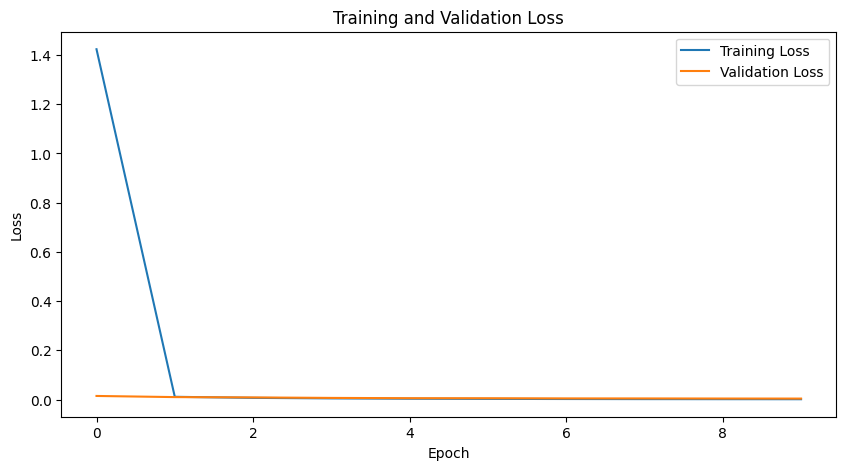

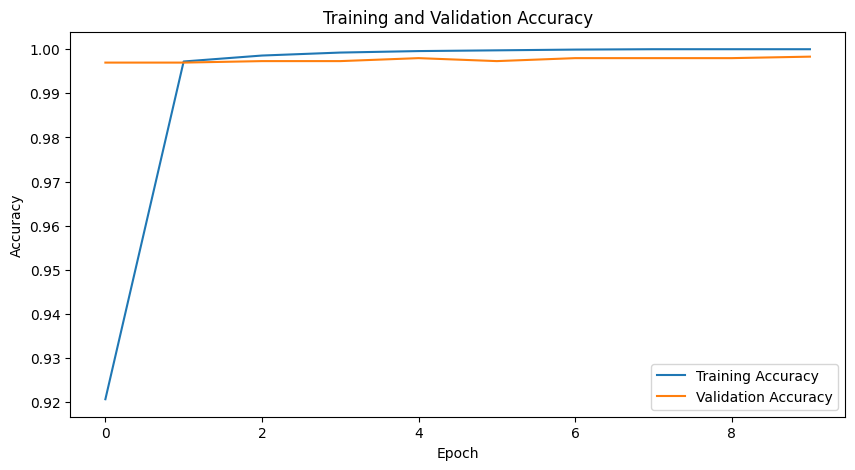

Epoch 1/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.59it/s]


train Loss: 1.0251 Acc: 0.9410


100%|██████████| 47/47 [00:10<00:00,  4.47it/s]


val Loss: 0.0094 Acc: 0.9973
Saving Best Model with Validation Accuracy:  0.9973054900639946
Epoch 2/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.70it/s]


train Loss: 0.0076 Acc: 0.9984


100%|██████████| 47/47 [00:10<00:00,  4.41it/s]


val Loss: 0.0067 Acc: 0.9980
Saving Best Model with Validation Accuracy:  0.997979117547996
Epoch 3/10
----------


100%|██████████| 186/186 [00:41<00:00,  4.43it/s]


train Loss: 0.0046 Acc: 0.9992


100%|██████████| 47/47 [00:10<00:00,  4.67it/s]


val Loss: 0.0055 Acc: 0.9980
Epoch 4/10
----------


100%|██████████| 186/186 [00:41<00:00,  4.50it/s]


train Loss: 0.0032 Acc: 0.9996


100%|██████████| 47/47 [00:10<00:00,  4.37it/s]


val Loss: 0.0052 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9986527450319973
Epoch 5/10
----------


100%|██████████| 186/186 [00:40<00:00,  4.62it/s]


train Loss: 0.0025 Acc: 0.9997


100%|██████████| 47/47 [00:09<00:00,  5.03it/s]


val Loss: 0.0057 Acc: 0.9980
Epoch 6/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.69it/s]


train Loss: 0.0020 Acc: 0.9998


100%|██████████| 47/47 [00:08<00:00,  5.23it/s]


val Loss: 0.0041 Acc: 0.9983
Epoch 7/10
----------


100%|██████████| 186/186 [00:38<00:00,  4.80it/s]


train Loss: 0.0016 Acc: 0.9999


100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


val Loss: 0.0040 Acc: 0.9987
Epoch 8/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.93it/s]


train Loss: 0.0013 Acc: 0.9999


100%|██████████| 47/47 [00:10<00:00,  4.69it/s]


val Loss: 0.0038 Acc: 0.9990
Saving Best Model with Validation Accuracy:  0.998989558773998
Epoch 9/10
----------


100%|██████████| 186/186 [00:37<00:00,  4.92it/s]


train Loss: 0.0011 Acc: 0.9999


100%|██████████| 47/47 [00:10<00:00,  4.62it/s]


val Loss: 0.0037 Acc: 0.9990
Epoch 10/10
----------


100%|██████████| 186/186 [00:39<00:00,  4.67it/s]


train Loss: 0.0009 Acc: 0.9999


100%|██████████| 47/47 [00:09<00:00,  4.90it/s]


val Loss: 0.0037 Acc: 0.9990
Training complete in 8m 18s
Best Validation Accuracy: 0.9990


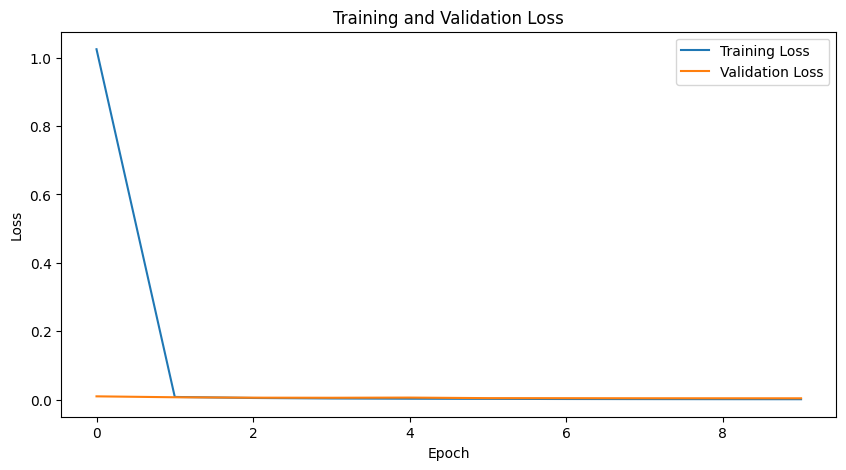

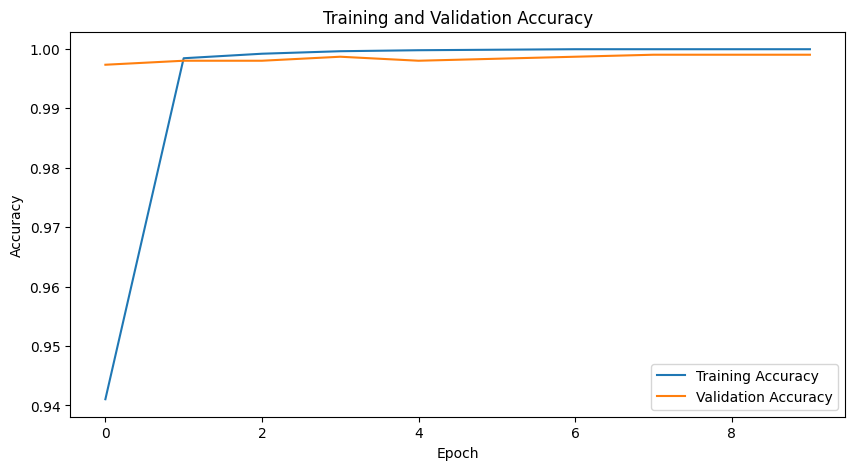

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_cp_cl0_cl2_{seed}" + "train.pt"))

### Left vs. Center Patch

In [ ]:
'''

# Define source and target directories
source_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_2'
target_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_2_half_first'

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# List all files in the source directory
all_files = os.listdir(source_dir)

# Sort files to ensure consistent ordering
all_files.sort()

# Determine the number of files to copy (first half of the total number of files)
num_files_to_copy = len(all_files) // 2

# Copy the first half of the files to the target directory
for file_name in all_files[:num_files_to_copy]:
    source_file = os.path.join(source_dir, file_name)
    target_file = os.path.join(target_dir, file_name)
    shutil.copy2(source_file, target_file)

print(f"Copied {num_files_to_copy} files from {source_dir} to {target_dir}")
'''

'\n\n# Define source and target directories\nsource_dir = \'/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_2\'\ntarget_dir = \'/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_right/train/class_2_half_first\'\n\n# Ensure target directory exists\nos.makedirs(target_dir, exist_ok=True)\n\n# List all files in the source directory\nall_files = os.listdir(source_dir)\n\n# Sort files to ensure consistent ordering\nall_files.sort()\n\n# Determine the number of files to copy (first half of the total number of files)\nnum_files_to_copy = len(all_files) // 2\n\n# Copy the first half of the files to the target directory\nfor file_name in all_files[:num_files_to_copy]:\n    source_file = os.path.join(source_dir, file_name)\n    target_file = os.path.join(target_dir, file_name)\n    shutil.copy2(source_file, target_file)\n\nprint(f"Copied {num_files_to_copy} files from {source_dir} to {target_dir}")\n'

In [ ]:
import shutil
'''
source_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_0'
target_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_0_half_second'

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# List all files in the source directory
all_files = os.listdir(source_dir)

# Sort files to ensure consistent ordering
all_files.sort()

# Determine the number of files to copy (second half of the total number of files)
num_files_to_copy = len(all_files) // 2

# Copy the second half of the files to the target directory
for file_name in all_files[num_files_to_copy:]:
    source_file = os.path.join(source_dir, file_name)
    target_file = os.path.join(target_dir, file_name)
    shutil.copy2(source_file, target_file)

print(f"Copied {len(all_files[num_files_to_copy:])} files from {source_dir} to {target_dir}")
'''

'\nsource_dir = \'/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_0\'\ntarget_dir = \'/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_0_half_second\'\n\n# Ensure target directory exists\nos.makedirs(target_dir, exist_ok=True)\n\n# List all files in the source directory\nall_files = os.listdir(source_dir)\n\n# Sort files to ensure consistent ordering\nall_files.sort()\n\n# Determine the number of files to copy (second half of the total number of files)\nnum_files_to_copy = len(all_files) // 2\n\n# Copy the second half of the files to the target directory\nfor file_name in all_files[num_files_to_copy:]:\n    source_file = os.path.join(source_dir, file_name)\n    target_file = os.path.join(target_dir, file_name)\n    shutil.copy2(source_file, target_file)\n\nprint(f"Copied {len(all_files[num_files_to_copy:])} files from {source_dir} to {target_dir}")\n'

In [ ]:
'''
source_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2'
target_dir = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2_half_first'

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# List all files in the source directory
all_files = os.listdir(source_dir)

# Sort files to ensure consistent ordering
all_files.sort()

# Determine the number of files to copy (second half of the total number of files)
num_files_to_copy = len(all_files) // 2

# Copy the second half of the files to the target directory
for file_name in all_files[:num_files_to_copy]:
    source_file = os.path.join(source_dir, file_name)
    target_file = os.path.join(target_dir, file_name)
    shutil.copy2(source_file, target_file)

print(f"Copied {len(all_files[:num_files_to_copy])} files from {source_dir} to {target_dir}")
'''

'\nsource_dir = \'/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2\'\ntarget_dir = \'/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2_half_first\'\n\n# Ensure target directory exists\nos.makedirs(target_dir, exist_ok=True)\n\n# List all files in the source directory\nall_files = os.listdir(source_dir)\n\n# Sort files to ensure consistent ordering\nall_files.sort()\n\n# Determine the number of files to copy (second half of the total number of files)\nnum_files_to_copy = len(all_files) // 2\n\n# Copy the second half of the files to the target directory\nfor file_name in all_files[:num_files_to_copy]:\n    source_file = os.path.join(source_dir, file_name)\n    target_file = os.path.join(target_dir, file_name)\n    shutil.copy2(source_file, target_file)\n\nprint(f"Copied {len(all_files[:num_files_to_copy])} files from {source_dir} to {target_dir}")\n'

In [ ]:
#Train
two_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_2_half_first'
zero_cp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/train/class_0_half_second'
two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2'
zero_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_0_half_first'

#Test
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'



# Create datasets for training and testing
dataset_two_cp = MnistDataset(path=two_cp_path, is_two=1, group_labels=[0] * len(os.listdir(two_cp_path)))
dataset_zero_cp = MnistDataset(path=zero_cp_path, is_two=0, group_labels=[2] * len(os.listdir(zero_cp_path)))
dataset_two_lp = MnistDataset(path=two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(two_lp_path)))
dataset_zero_lp = MnistDataset(path=zero_lp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_lp_path)))
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_cp, dataset_zero_lp, dataset_two_lp))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_lp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



num_train: 9504
num_val: 2377
num_test: 1032


Epoch 1/10
----------


100%|██████████| 149/149 [18:26<00:00,  7.43s/it]


train Loss: 2.1199 Acc: 0.9065


100%|██████████| 38/38 [04:26<00:00,  7.00s/it]


val Loss: 0.0152 Acc: 0.9958
Saving Best Model with Validation Accuracy:  0.995793016407236
Epoch 2/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.93it/s]


train Loss: 0.0135 Acc: 0.9966


100%|██████████| 38/38 [00:07<00:00,  5.04it/s]


val Loss: 0.0108 Acc: 0.9966
Saving Best Model with Validation Accuracy:  0.9966344131257888
Epoch 3/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.82it/s]


train Loss: 0.0091 Acc: 0.9979


100%|██████████| 38/38 [00:06<00:00,  5.49it/s]


val Loss: 0.0088 Acc: 0.9975
Saving Best Model with Validation Accuracy:  0.9974758098443416
Epoch 4/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.87it/s]


train Loss: 0.0067 Acc: 0.9985


100%|██████████| 38/38 [00:08<00:00,  4.70it/s]


val Loss: 0.0074 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987379049221708
Epoch 5/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.91it/s]


train Loss: 0.0048 Acc: 0.9996


100%|██████████| 38/38 [00:06<00:00,  5.50it/s]


val Loss: 0.0080 Acc: 0.9966
Epoch 6/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.71it/s]


train Loss: 0.0040 Acc: 0.9995


100%|██████████| 38/38 [00:08<00:00,  4.71it/s]


val Loss: 0.0067 Acc: 0.9979
Epoch 7/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.72it/s]


train Loss: 0.0031 Acc: 0.9999


100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


val Loss: 0.0058 Acc: 0.9983
Epoch 8/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.67it/s]


train Loss: 0.0027 Acc: 0.9998


100%|██████████| 38/38 [00:07<00:00,  5.34it/s]


val Loss: 0.0058 Acc: 0.9983
Epoch 9/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.83it/s]


train Loss: 0.0023 Acc: 1.0000


100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


val Loss: 0.0051 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.80it/s]


train Loss: 0.0019 Acc: 1.0000


100%|██████████| 38/38 [00:08<00:00,  4.52it/s]


val Loss: 0.0052 Acc: 0.9983
Training complete in 28m 41s
Best Validation Accuracy: 0.9987


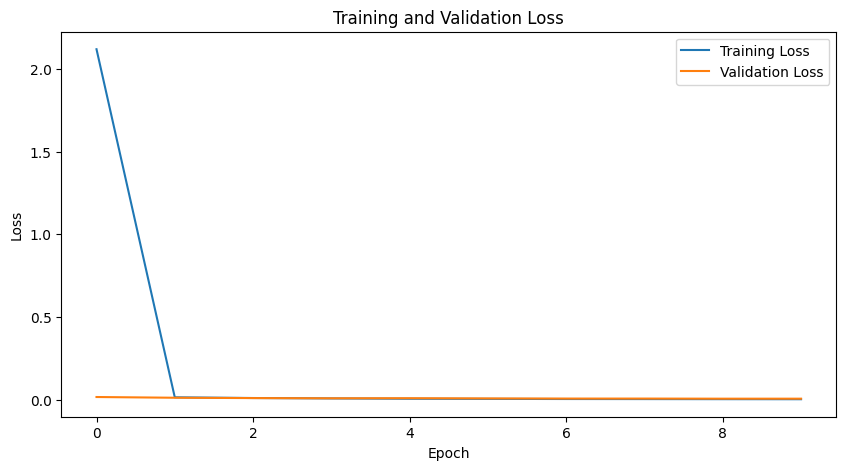

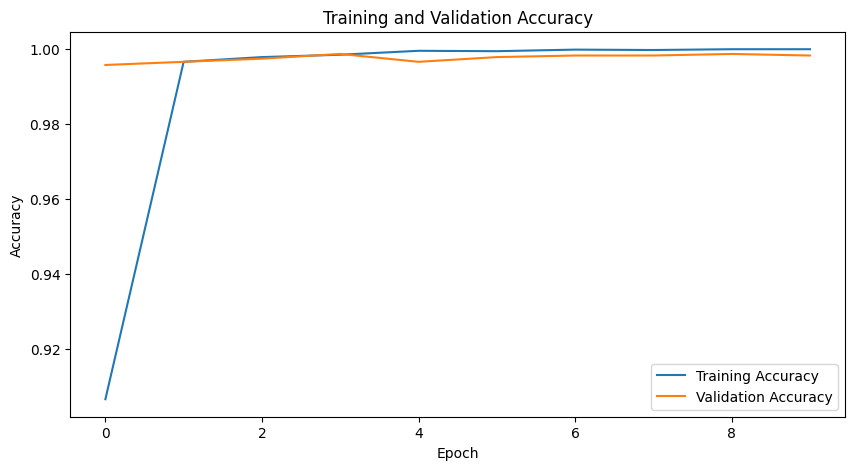

Epoch 1/10
----------


100%|██████████| 149/149 [00:33<00:00,  4.51it/s]


train Loss: 0.9662 Acc: 0.9411


100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


val Loss: 0.0070 Acc: 0.9971
Saving Best Model with Validation Accuracy:  0.9970551114850652
Epoch 2/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.63it/s]


train Loss: 0.0056 Acc: 0.9980


100%|██████████| 38/38 [00:08<00:00,  4.68it/s]


val Loss: 0.0041 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987379049221708
Epoch 3/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.61it/s]


train Loss: 0.0030 Acc: 0.9991


100%|██████████| 38/38 [00:08<00:00,  4.33it/s]


val Loss: 0.0029 Acc: 0.9992
Saving Best Model with Validation Accuracy:  0.9991586032814472
Epoch 4/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.74it/s]


train Loss: 0.0017 Acc: 0.9998


100%|██████████| 38/38 [00:07<00:00,  4.80it/s]


val Loss: 0.0036 Acc: 0.9992
Epoch 5/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.60it/s]


train Loss: 0.0012 Acc: 0.9999


100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


val Loss: 0.0035 Acc: 0.9992
Epoch 6/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.74it/s]


train Loss: 0.0009 Acc: 1.0000


100%|██████████| 38/38 [00:08<00:00,  4.50it/s]


val Loss: 0.0035 Acc: 0.9992
Epoch 7/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.79it/s]


train Loss: 0.0008 Acc: 1.0000


100%|██████████| 38/38 [00:07<00:00,  5.31it/s]


val Loss: 0.0029 Acc: 0.9992
Epoch 8/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.82it/s]


train Loss: 0.0007 Acc: 1.0000


100%|██████████| 38/38 [00:07<00:00,  4.92it/s]


val Loss: 0.0031 Acc: 0.9992
Epoch 9/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.72it/s]


train Loss: 0.0006 Acc: 1.0000


100%|██████████| 38/38 [00:08<00:00,  4.59it/s]


val Loss: 0.0034 Acc: 0.9992
Epoch 10/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.80it/s]


train Loss: 0.0005 Acc: 1.0000


100%|██████████| 38/38 [00:06<00:00,  5.57it/s]


val Loss: 0.0026 Acc: 0.9992
Training complete in 6m 36s
Best Validation Accuracy: 0.9992


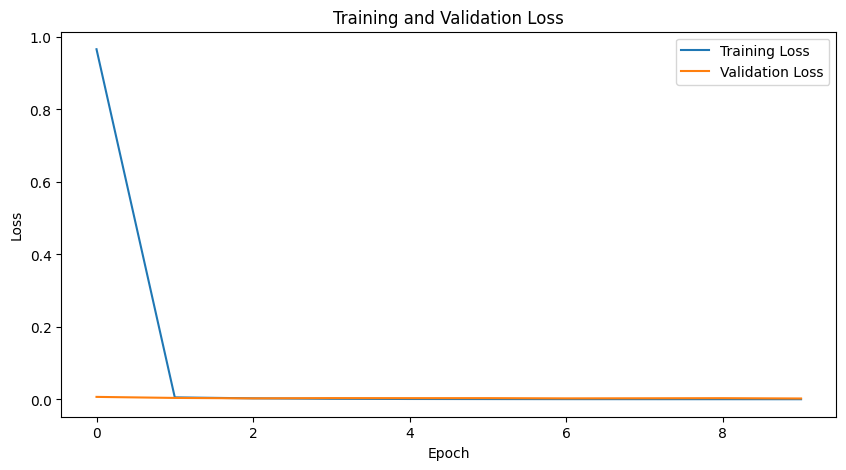

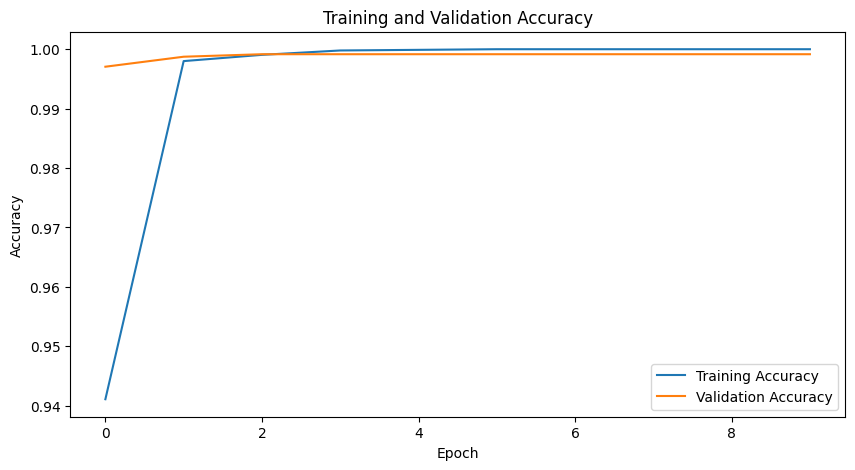

Epoch 1/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.55it/s]


train Loss: 1.8004 Acc: 0.9014


100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


val Loss: 0.0145 Acc: 0.9954
Saving Best Model with Validation Accuracy:  0.9953723180479597
Epoch 2/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.59it/s]


train Loss: 0.0116 Acc: 0.9965


100%|██████████| 38/38 [00:08<00:00,  4.60it/s]


val Loss: 0.0146 Acc: 0.9937
Epoch 3/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.67it/s]


train Loss: 0.0079 Acc: 0.9979


100%|██████████| 38/38 [00:07<00:00,  5.36it/s]


val Loss: 0.0071 Acc: 0.9979
Saving Best Model with Validation Accuracy:  0.9978965082036181
Epoch 4/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.80it/s]


train Loss: 0.0054 Acc: 0.9992


100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


val Loss: 0.0058 Acc: 0.9979
Epoch 5/10
----------


100%|██████████| 149/149 [00:30<00:00,  4.88it/s]


train Loss: 0.0043 Acc: 0.9999


100%|██████████| 38/38 [00:08<00:00,  4.73it/s]


val Loss: 0.0053 Acc: 0.9987
Saving Best Model with Validation Accuracy:  0.9987379049221708
Epoch 6/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.71it/s]


train Loss: 0.0033 Acc: 0.9999


100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


val Loss: 0.0051 Acc: 0.9987
Epoch 7/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.78it/s]


train Loss: 0.0028 Acc: 0.9999


100%|██████████| 38/38 [00:08<00:00,  4.58it/s]


val Loss: 0.0044 Acc: 0.9983
Epoch 8/10
----------


100%|██████████| 149/149 [00:32<00:00,  4.65it/s]


train Loss: 0.0023 Acc: 0.9999


100%|██████████| 38/38 [00:07<00:00,  4.82it/s]


val Loss: 0.0043 Acc: 0.9983
Epoch 9/10
----------


100%|██████████| 149/149 [00:33<00:00,  4.41it/s]


train Loss: 0.0020 Acc: 0.9999


100%|██████████| 38/38 [00:08<00:00,  4.74it/s]


val Loss: 0.0041 Acc: 0.9987
Epoch 10/10
----------


100%|██████████| 149/149 [00:31<00:00,  4.71it/s]


train Loss: 0.0017 Acc: 0.9999


100%|██████████| 38/38 [00:08<00:00,  4.61it/s]


val Loss: 0.0038 Acc: 0.9987
Training complete in 6m 38s
Best Validation Accuracy: 0.9987


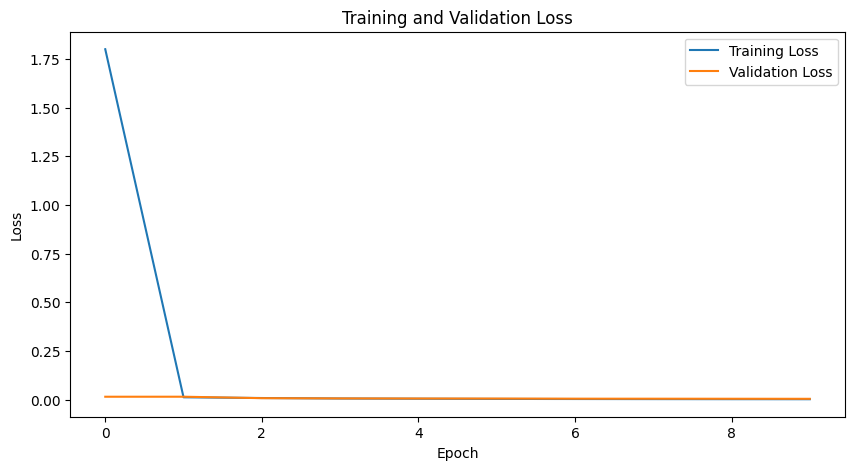

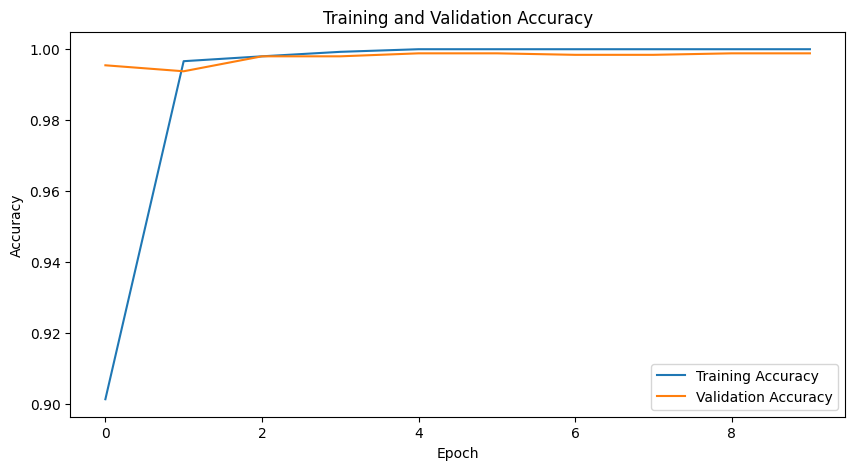

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_cp_lp_cl0_cl2_{seed}" + "train.pt"))

### Dynamic Left Patch

In [ ]:
#Train
two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_2'
zero_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/train/class_0_half'
zero_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/train/class_0_half_second'

#Test
test_two_lp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'



# Create datasets for training and testing
dataset_two_org = MnistDataset(path=two_org_path, is_two=1, group_labels=[0] * len(os.listdir(two_org_path)))
dataset_zero_org = MnistDataset(path=zero_org_path, is_two=0, group_labels=[2] * len(os.listdir(zero_org_path)))
#dataset_two_lp = MnistDataset(path=two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(two_lp_path)))
dataset_zero_lp = MnistDataset(path=zero_lp_path, is_two=0, group_labels=[3] * len(os.listdir(zero_lp_path)))
dataset_test_two_lp = MnistDataset(path=test_two_lp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_lp_path)))

# Concatenate the training datasets
complete_dataset = ConcatDataset((dataset_zero_org, dataset_zero_lp, dataset_two_org))

# Set the random seed for reproducibility
seed = 1
torch.manual_seed(seed)

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(complete_dataset))
val_size = len(complete_dataset) - train_size
train_dataset, val_dataset = random_split(complete_dataset, [train_size, val_size])

# Use the test dataset as is
test_dataset = dataset_test_two_lp

batch_size = 64

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Validate input data
#if not validate_inputs(train_loader):
#    print("Input data contains invalid values.")

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Print dataset sizes
print("num_train:", dataset_sizes['train'])
print("num_val:", dataset_sizes['val'])
print("num_test:", dataset_sizes['test'])



In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


# Define arguments
class Args:
    def __init__(self, seed):
        self.batch_size = 64 #16
        self.epochs = 10
        self.lr = 0.0001  # Lower the learning rate
        self.momentum = 0.9
        self.seed = seed
        self.regularizer_rate = 0.0
        #self.dropout_rate = 0.7

seeds = [1, 11, 111]

for seed in seeds:
    args = Args(seed)

    # Set random seed for reproducibility
    torch.manual_seed(args.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model, optimizer, and loss function
    model = AlexNet().to(device)
    initialize_weights(model)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()  # Change to CrossEntropyLoss for multi-class classification

    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=args.epochs, resume_training=False)
    pid = datetime.now().strftime('%Y%m%d%H%M%S')
    torch.save(model.state_dict(), os.path.join(dir_path, model_path, f"alexnet_mnist_dyn_lp_cl0_cl2_{seed}" + "train.pt"))

In [ ]:
import torch
import os
from torch.utils.data import DataLoader
import torch.nn as nn
from datetime import datetime

# Function to load the trained model
def load_model(model_path, device):
    model = AlexNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Function to test the model on a specific dataset
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:  # Ignore group_label
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total * 100
    return accuracy


# Define paths to the test datasets
test_two_dlp_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/test/class_2'
test_two_org_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

# Create test datasets
dataset_test_two_dlp = MnistDataset(path=test_two_dlp_path, is_two=1, group_labels=[1] * len(os.listdir(test_two_dlp_path)))
dataset_test_two_org = MnistDataset(path=test_two_org_path, is_two=1, group_labels=[0] * len(os.listdir(test_two_org_path)))

# Create dataloaders for the test datasets
batch_size = 64
test_loader_dlp = DataLoader(dataset_test_two_dlp, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader_org = DataLoader(dataset_test_two_org, batch_size=batch_size, shuffle=False, num_workers=2)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and test the model for each seed
seeds = [1, 11, 111]
for seed in seeds:
    model_path = f"/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_dyn_lp_cl0_cl2_{seed}train.pt"

    print(f"\nLoading model with seed {seed}")
    model = load_model(model_path, device)

    # Test on patches_left dataset
    accuracy_dlp = test_model(model, test_loader_dlp, device)
    print(f"Accuracy on dynamic patches_left test dataset (class_2): {accuracy_dlp:.2f}%")

    # Test on original dataset
    accuracy_org = test_model(model, test_loader_org, device)
    print(f"Accuracy on original test dataset (class_2): {accuracy_org:.2f}%")



Loading model with seed 1


<ipython-input-14-d12dd8f775f9>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Accuracy on dynamic patches_left test dataset (class_2): 57.36%
Accuracy on original test dataset (class_2): 99.42%

Loading model with seed 11
Accuracy on dynamic patches_left test dataset (class_2): 56.59%
Accuracy on original test dataset (class_2): 99.71%

Loading model with seed 111
Accuracy on dynamic patches_left test dataset (class_2): 82.75%
Accuracy on original test dataset (class_2): 99.52%


## Activation Extraction

### Original vs. Colored Background

#### Correlation

Computing activations and saving to activations.npy


<ipython-input-17-584663aaeb60>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


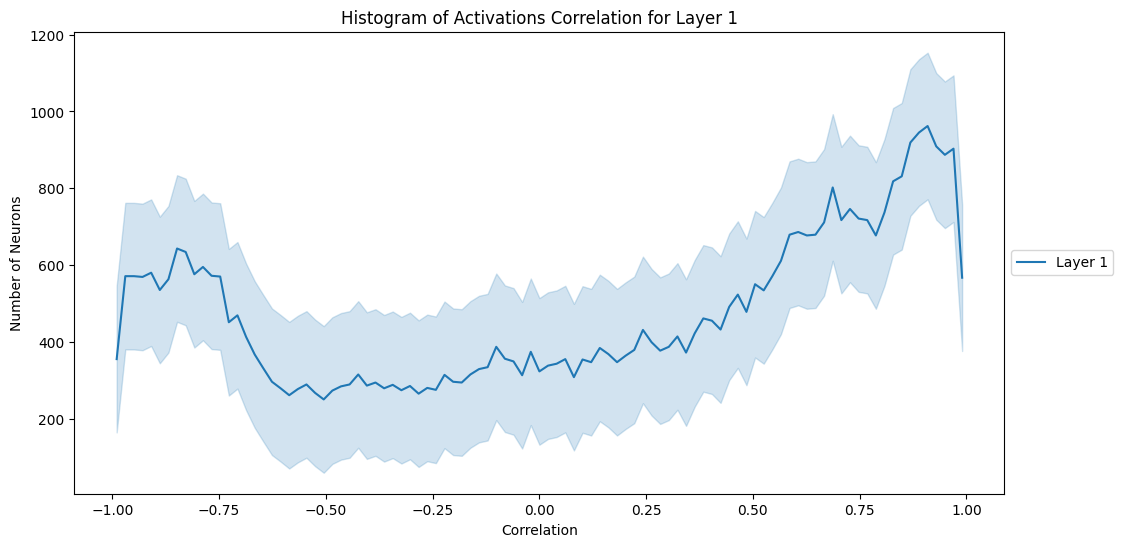

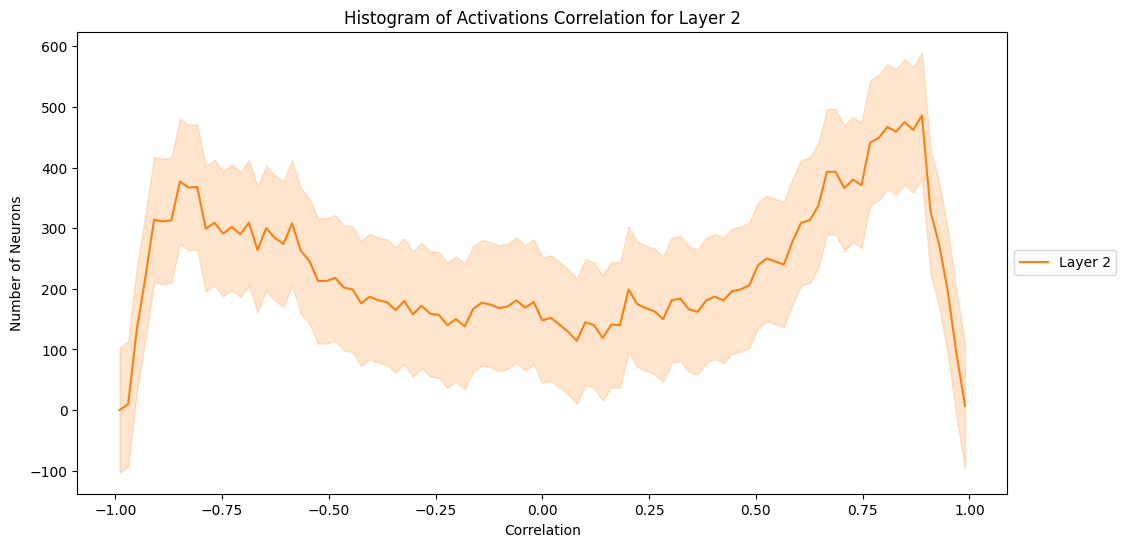

<ipython-input-17-584663aaeb60>:190: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


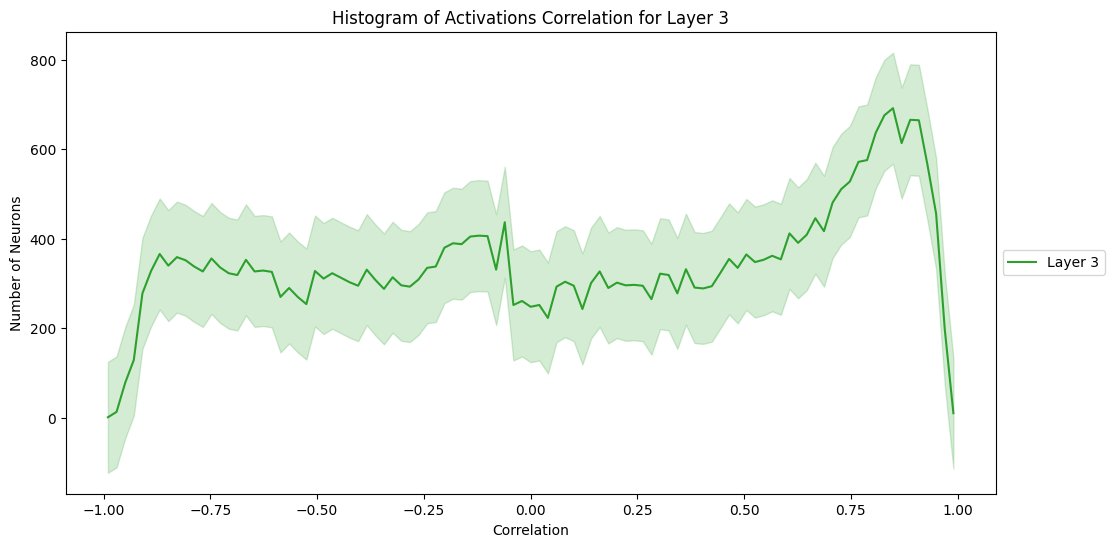

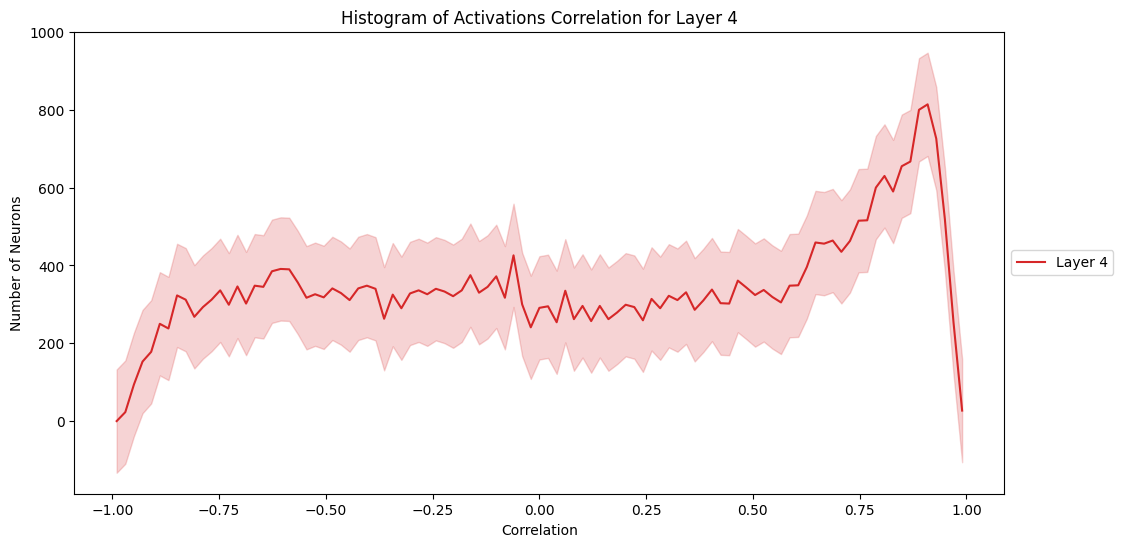

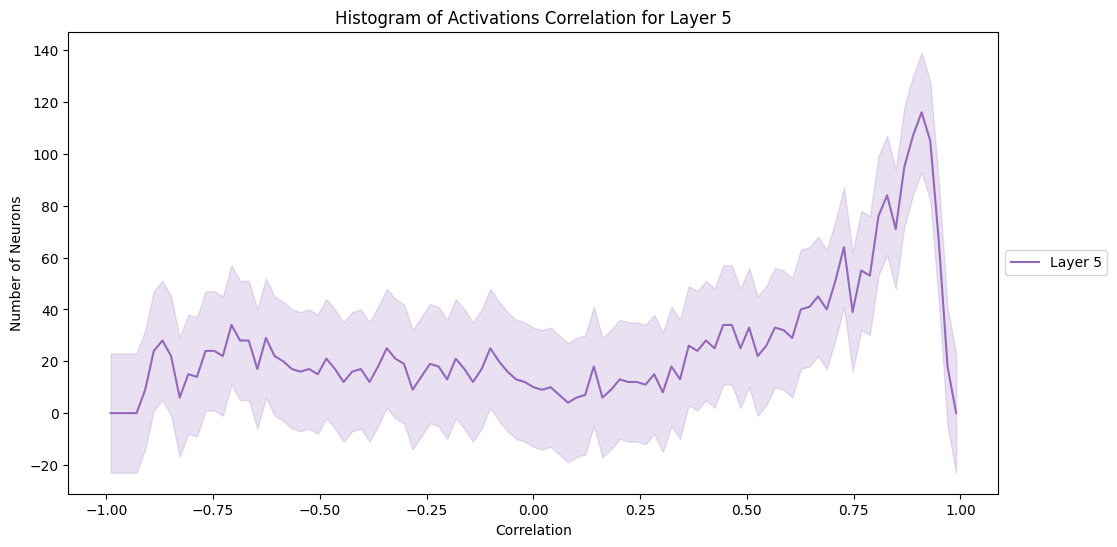

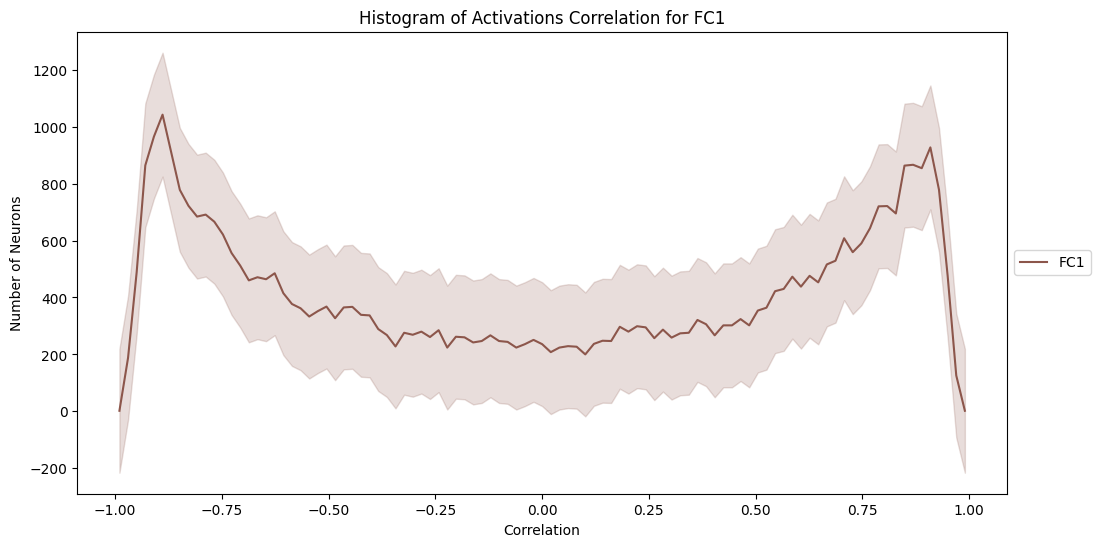

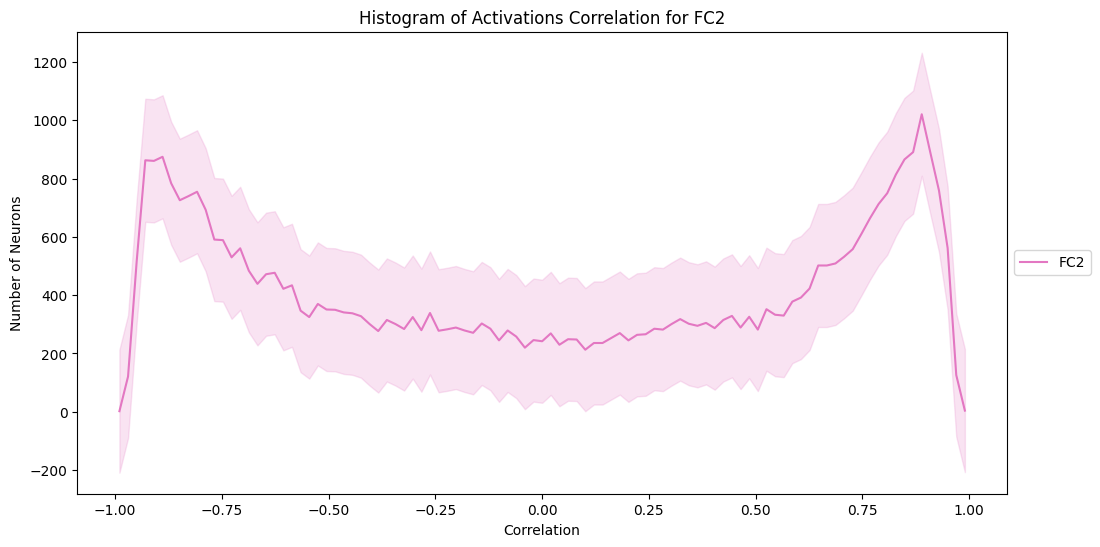

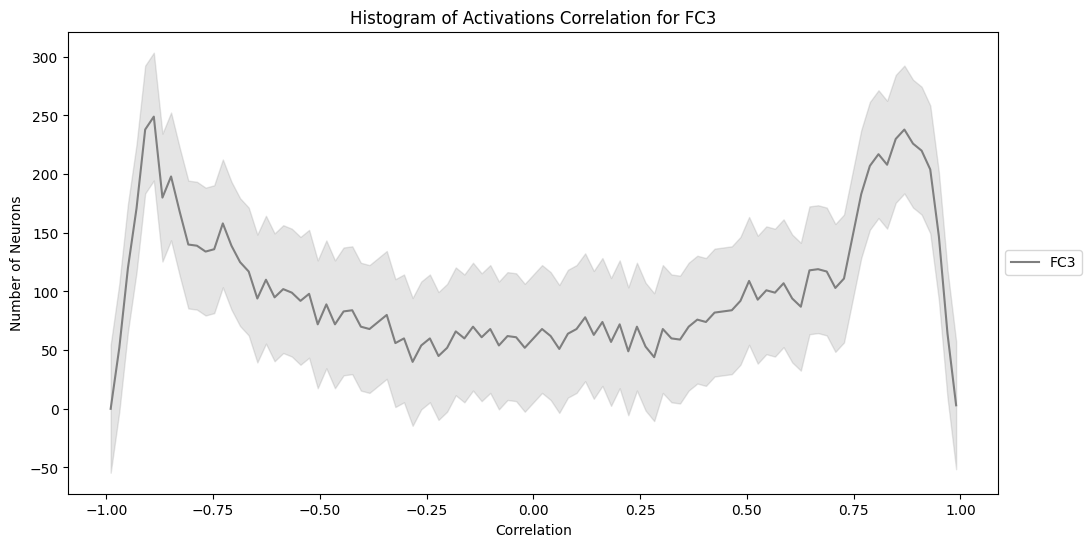

<ipython-input-17-584663aaeb60>:228: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])


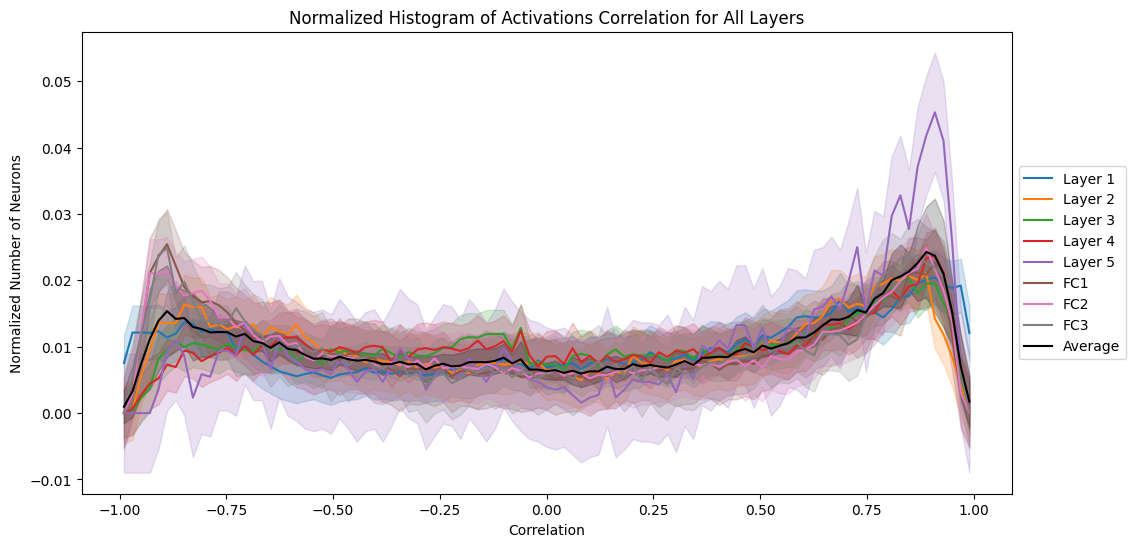

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations


def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/background/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('background', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'background', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

bg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/background/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_bg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_bg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_bg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, bg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample t-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)

# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both background and original conditions
background_activations = {layer: load_activations('background', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(background_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
#plot_p_values(t_test_results)


Layer 0:
  WP Activations:
    Mean: 2.2018
  WO Activations:
    Mean: 1.8976
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 87.42%
    Percentage of neurons with raw p-value <= 0.02: 84.97%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 70.10%
    Percentage of neurons with adjusted p-value <= 0.02: 69.08%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 2.0785
  WO Activations:
    Mean: 1.9095
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 81.31%
    Percentage of neurons with raw p-value <= 0.02: 77.93%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 56.12%
    Percentage of neurons with adjusted p-value <= 0.02: 54.52%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.9079
  WO Activations:
    Mean: 0.7468
  T-Tes

### Original vs. Colored Digit (Foreground - fg)

#### Correlation

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/foreground/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('foreground', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'foreground', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

fg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, fg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
#layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
#for idx, (layer, layer_name) in enumerate(layer_names.items()):
#    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
#plot_combined_histogram(layer_avg_std, layer_names, colors)


Computing activations and saving to activations.npy


improved version for more efficient data loading and processing images in smaller batches and clears memory after

In [ ]:
'''
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Match the normalization values in MnistDataset
])

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image

def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            if layer == 0:  # Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc1(tensor)
            elif layer == 6:  # FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # FC3
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 7 * 7)
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations

def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/foreground/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('foreground', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'foreground', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

fg_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/foreground/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_fg_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, fg_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

plot_combined_histogram(layer_avg_std, layer_names, colors)
'''


'\nimport os\nimport numpy as np\nimport torch\nfrom torchvision import models, transforms\nfrom PIL import Image\nimport matplotlib.pyplot as plt\nimport gc\nfrom scipy.stats import pearsonr\nfrom torch.utils.data import DataLoader, Dataset\n\ndef load_model(model_path):\n    model = AlexNet()\n    model.load_state_dict(torch.load(model_path, map_location=device))\n    model.to(device)\n    model.eval()\n    return model\n\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\n\n# Preprocessing function\npreprocess = transforms.Compose([\n    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset\n    transforms.ToTensor(),\n    transforms.Normalize((0.5,), (0.5,))  # Match the normalization values in MnistDataset\n])\n\nclass ImageDataset(Dataset):\n    def __init__(self, image_paths, transform=None):\n        self.image_paths = image_paths\n        self.transform = transform\n\n    def __len__(self):\n        return len(self.image_paths)\n\n    d

#### Two sample t-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)


# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both foreground and original conditions
foreground_activations = {layer: load_activations('foreground', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(foreground_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
#plot_p_values(t_test_results)


Layer 0:
  WP Activations:
    Mean: 1.3723
  WO Activations:
    Mean: 1.9012
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 70.18%
    Percentage of neurons with raw p-value <= 0.02: 66.11%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 43.98%
    Percentage of neurons with adjusted p-value <= 0.02: 42.77%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.4172
  WO Activations:
    Mean: 2.0591
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 81.00%
    Percentage of neurons with raw p-value <= 0.02: 77.38%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 55.17%
    Percentage of neurons with adjusted p-value <= 0.02: 53.46%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.6210
  WO Activations:
    Mean: 0.8250
  T-Tes

### Original vs. Left Patch (lp)

#### Correlations

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('left_patch', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'left_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

olp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, olp_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
#layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
#for idx, (layer, layer_name) in enumerate(layer_names.items()):
#    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
#plot_combined_histogram(layer_avg_std, layer_names, colors)


Computing activations and saving to activations.npy


#### Two sample t-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)


# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both left_patch and original conditions
left_patch_activations = {layer: load_activations('left_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(left_patch_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
#plot_p_values(t_test_results)


Layer 0:
  WP Activations:
    Mean: 1.9329
  WO Activations:
    Mean: 1.8787
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 8.77%
    Percentage of neurons with raw p-value <= 0.02: 6.95%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 4.17%
    Percentage of neurons with adjusted p-value <= 0.02: 4.13%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.9263
  WO Activations:
    Mean: 1.8823
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 10.81%
    Percentage of neurons with raw p-value <= 0.02: 8.44%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 1.54%
    Percentage of neurons with adjusted p-value <= 0.02: 1.36%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.7002
  WO Activations:
    Mean: 0.6932
  T-Test (befo

### Original vs. Center Patch

#### Correlations

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/center_patch/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('center_patch', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'center_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_0'
cp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_0'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_cp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_cp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_cp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, org_mnist_folder_path, cp_mnist_folder_path, layers_of_interest)
#layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
#for idx, (layer, layer_name) in enumerate(layer_names.items()):
#    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
#plot_combined_histogram(layer_avg_std, layer_names, colors)


Computing activations and saving to activations.npy


#### Two sample t-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)


# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both original and center_patch conditions
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
center_patch_activations = {layer: load_activations('center_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(original_activations, center_patch_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
#plot_p_values(t_test_results)


Layer 0:
  WP Activations:
    Mean: 1.9975
  WO Activations:
    Mean: 2.0559
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 6.08%
    Percentage of neurons with raw p-value <= 0.02: 5.92%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 4.61%
    Percentage of neurons with adjusted p-value <= 0.02: 4.56%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.7858
  WO Activations:
    Mean: 1.8308
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 10.86%
    Percentage of neurons with raw p-value <= 0.02: 8.70%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 1.90%
    Percentage of neurons with adjusted p-value <= 0.02: 1.69%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5892
  WO Activations:
    Mean: 0.5992
  T-Test (befo

### Center vs. Left Patch

#### Correlation

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/center_patch/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/left_patch/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('center_patch', activations_file)
        wo_activations = load_activations('left_patch', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'center_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'left_patch', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

olp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
cp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'

model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_cp_lp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_cp_lp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_cp_lp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, olp_mnist_folder_path, cp_mnist_folder_path, layers_of_interest)
#layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
#for idx, (layer, layer_name) in enumerate(layer_names.items()):
#    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
#plot_combined_histogram(layer_avg_std, layer_names, colors)


Computing activations and saving to activations.npy


#### Two sample t-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)



# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both left_patch and center_patch conditions
left_patch_activations = {layer: load_activations('left_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
center_patch_activations = {layer: load_activations('center_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(left_patch_activations, center_patch_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
#plot_p_values(t_test_results)


Layer 0:
  WP Activations:
    Mean: 1.8920
  WO Activations:
    Mean: 1.9064
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 16.27%
    Percentage of neurons with raw p-value <= 0.02: 14.58%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 8.60%
    Percentage of neurons with adjusted p-value <= 0.02: 8.33%
--------------------------------------------------
Layer 1:
  WP Activations:
    Mean: 1.6844
  WO Activations:
    Mean: 1.6769
  T-Test (before Bonferroni correction):
    Percentage of neurons with raw p-value <= 0.05: 28.14%
    Percentage of neurons with raw p-value <= 0.02: 21.54%
  T-Test (after Bonferroni correction):
    Percentage of neurons with adjusted p-value <= 0.05: 3.72%
    Percentage of neurons with adjusted p-value <= 0.02: 3.26%
--------------------------------------------------
Layer 2:
  WP Activations:
    Mean: 0.5893
  WO Activations:
    Mean: 0.5767
  T-Test (b

In [ ]:
'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

image_file_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2/2_2.png'

img = Image.open(image_file_path).convert("RGB")

# Apply the transformations
transformed_img = preprocess(img)

# Convert the transformed tensor back to a NumPy array for visualization
img_np = transformed_img.numpy().transpose((1, 2, 0))  # Change dimensions from [C, H, W] to [H, W, C]

# Reverse the normalization for visualization (optional "un-normalized" image)
#img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
#img_np = np.clip(img_np, 0, 1)  # Clip values to be between 0 and 1 for visualization

# Display the image
plt.imshow(img_np)
plt.title('Transformed Image Used in Extractions')
plt.axis('off')
plt.show()
'''

'\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\n\n# Preprocessing function\npreprocess = transforms.Compose([\n    transforms.Resize((64, 64)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats\n])\n\nimage_file_path = \'/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/train/class_2/2_2.png\'\n\nimg = Image.open(image_file_path).convert("RGB")\n\n# Apply the transformations\ntransformed_img = preprocess(img)\n\n# Convert the transformed tensor back to a NumPy array for visualization\nimg_np = transformed_img.numpy().transpose((1, 2, 0))  # Change dimensions from [C, H, W] to [H, W, C]\n\n# Reverse the normalization for visualization (optional "un-normalized" image)\n#img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])\n#img_np = np.clip(img_np, 0, 1)  # Clip values to be between 0 and 1 for visualization\

### Dynamic Left Patch

#### Corelation

In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
from torch.utils.data import DataLoader, Dataset

def load_model(model_path):
    model = AlexNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),  # Match the resize shape in MnistDataset
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Match the normalization values in MnistDataset
])


class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


def preprocess_and_extract_activations(model, dataloader, layer):
    activations = []
    with torch.no_grad():
        for image_tensor in dataloader:
            image_tensor = image_tensor.to(device)

            # Extract activations according to the AlexNet model's structure
            if layer == 0:  # After Layer 1
                tensor = model.layer1(image_tensor)
            elif layer == 1:  # After Layer 2
                tensor = model.layer2(model.layer1(image_tensor))
            elif layer == 2:  # After Layer 3
                tensor = model.layer3(model.layer2(model.layer1(image_tensor)))
            elif layer == 3:  # After Layer 4
                tensor = model.layer4(model.layer3(model.layer2(model.layer1(image_tensor))))
            elif layer == 4:  # After Layer 5
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
            elif layer == 5:  # After FC1
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc1(tensor)
            elif layer == 6:  # After FC2
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc2(model.fc1(tensor))
            elif layer == 7:  # After FC3 (Output)
                tensor = model.layer5(model.layer4(model.layer3(model.layer2(model.layer1(image_tensor)))))
                tensor = tensor.view(-1, 256 * 1 * 1)  # Reshape to match the input to FC1
                tensor = model.fc3(model.fc2(model.fc1(tensor)))

            activation = tensor.cpu().numpy()
            activations.append(activation)

            # Clear memory
            del tensor
            torch.cuda.empty_cache()
            gc.collect()

    return activations



def process_images_in_folder(model, folder_path, layer, batch_size=10):
    all_layer_activations = []

    image_paths = [os.path.join(root, file)
                   for root, dirs, files in os.walk(folder_path)
                   for file in files if file.endswith('.png')]

    dataset = ImageDataset(image_paths=image_paths, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Process in smaller batches to avoid memory issues
    for i, batch in enumerate(dataloader):
        batch_activations = preprocess_and_extract_activations(model, [batch], layer)
        all_layer_activations.extend(batch_activations)
        torch.cuda.empty_cache()
        gc.collect()

    return all_layer_activations

def flatten_and_align_activations(activations_list):
    # Flatten activations and find the maximum length
    flat_activations = [act.flatten() for act in activations_list]
    max_length = max(len(act) for act in flat_activations)

    # Pad or truncate activations to the maximum length
    aligned_activations = []
    for activation in flat_activations:
        if len(activation) < max_length:
            padded_activation = np.pad(activation, (0, max_length - len(activation)), 'constant')
        else:
            padded_activation = activation[:max_length]
        aligned_activations.append(padded_activation)
    return np.vstack(aligned_activations)

def save_activations(all_layer_activations, folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    np.save(drive_path, all_layer_activations)

def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True).item()

def compute_activations_for_layers(model_paths, patch_folder, no_patch_folder, layers, activations_file='activations.npy'):
    if os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/original/{activations_file}') and \
       os.path.exists(f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/dynamic_left_patch/{activations_file}'):
        print(f"Loading activations from {activations_file}")
        wp_activations = load_activations('dynamic_left_patch', activations_file)
        wo_activations = load_activations('original', activations_file)
        return {layer: {'wp': wp_activations[layer], 'wo': wo_activations[layer]} for layer in layers}

    print(f"Computing activations and saving to {activations_file}")
    all_layer_activations = {layer: {'wp': [], 'wo': []} for layer in layers}

    for model_path in model_paths:
        model = load_model(model_path)
        for layer in layers:
            wp_activations = process_images_in_folder(model, patch_folder, layer)
            wo_activations = process_images_in_folder(model, no_patch_folder, layer)
            all_layer_activations[layer]['wp'].append(flatten_and_align_activations(wp_activations))
            all_layer_activations[layer]['wo'].append(flatten_and_align_activations(wo_activations))
        del model  # Free model resources after use
        torch.cuda.empty_cache()
        gc.collect()

    for layer in layers:
        save_activations(all_layer_activations[layer]['wp'], 'dynamic_left_patch', f'{activations_file}_{layer}.npy')
        save_activations(all_layer_activations[layer]['wo'], 'original', f'{activations_file}_{layer}.npy')

    return all_layer_activations

def compute_avg_std_activations(all_layer_activations, layers):
    layer_avg_std = {layer: {'wp_avg': None, 'wo_avg': None, 'wp_std': None, 'wo_std': None} for layer in layers}

    for layer in layers:
        wp_all_models_layer_activations = np.stack(all_layer_activations[layer]['wp'], axis=0)
        wo_all_models_layer_activations = np.stack(all_layer_activations[layer]['wo'], axis=0)

        wp_avg = np.mean(wp_all_models_layer_activations, axis=0)
        wo_avg = np.mean(wo_all_models_layer_activations, axis=0)
        wp_std = np.std(wp_all_models_layer_activations, axis=0)
        wo_std = np.std(wo_all_models_layer_activations, axis=0)

        layer_avg_std[layer]['wp_avg'] = wp_avg
        layer_avg_std[layer]['wo_avg'] = wo_avg
        layer_avg_std[layer]['wp_std'] = wp_std
        layer_avg_std[layer]['wo_std'] = wo_std

    return layer_avg_std

def plot_histogram_for_layer(layer_avg_std, layer, layer_name, color):
    wp_avg = layer_avg_std[layer]['wp_avg']
    wo_avg = layer_avg_std[layer]['wo_avg']
    wp_std = layer_avg_std[layer]['wp_std']
    wo_std = layer_avg_std[layer]['wo_std']

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
    combined_activations = np.vstack((wo_avg, wp_avg))

    A = []
    for ii in range(combined_activations.shape[1]):
        A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

    B = np.histogram(A, bins=x)

    bin_means = B[0]
    bin_stds = np.std(bin_means)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(xaxis, bin_means, '-', color=color, label=layer_name)
    ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.2)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'Histogram of Activations Correlation for {layer_name}')
    plt.xlabel('Correlation')
    plt.ylabel('Number of Neurons')
    plt.show()

def plot_combined_histogram(layer_avg_std, layer_names, colors):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)

    x = np.linspace(start=-1, stop=1, num=100)
    xaxis = x + (x[1] - x[0]) / 2
    xaxis = xaxis[:-1]

    all_layer_bin_means = []

    for idx, (layer, layer_name) in enumerate(layer_names.items()):
        wp_avg = layer_avg_std[layer]['wp_avg']
        wo_avg = layer_avg_std[layer]['wo_avg']
        wp_std = layer_avg_std[layer]['wp_std']
        wo_std = layer_avg_std[layer]['wo_std']

        patch_no_patch = np.hstack([np.zeros(len(wo_avg)), np.ones(len(wp_avg))])
        combined_activations = np.vstack((wo_avg, wp_avg))

        A = []
        for ii in range(combined_activations.shape[1]):
            A.append(pearsonr(patch_no_patch, combined_activations[:, ii])[0])

        B = np.histogram(A, bins=x)

        bin_means = B[0] / np.sum(B[0])  # Normalize the bin counts
        bin_stds = np.std(bin_means)

        all_layer_bin_means.append(bin_means)

        ax.plot(xaxis, bin_means, '-', color=colors[idx], label=layer_name)
        ax.fill_between(xaxis, bin_means - bin_stds, bin_means + bin_stds, color=colors[idx], alpha=0.2)

    # Compute average and standard deviation of the normalized histograms across layers
    all_layer_bin_means = np.array(all_layer_bin_means)
    avg_bin_means = np.mean(all_layer_bin_means, axis=0)
    std_bin_means = np.std(all_layer_bin_means, axis=0)

    ax.plot(xaxis, avg_bin_means, '-', color='black', label='Average')
    ax.fill_between(xaxis, avg_bin_means - std_bin_means, avg_bin_means + std_bin_means, color='black', alpha=0.2)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Normalized Histogram of Activations Correlation for All Layers')
    plt.xlabel('Correlation')
    plt.ylabel('Normalized Number of Neurons')
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers
layer_names = {
    0: "Layer 1",
    1: "Layer 2",
    2: "Layer 3",
    3: "Layer 4",
    4: "Layer 5",
    5: "FC1",
    6: "FC2",
    7: "FC3"
}
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

olp_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/dynamic_patches_left/test/class_2'
org_mnist_folder_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/original/test/class_2'


model_paths = [
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_dyn_lp_cl0_cl2_1train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_dyn_lp_cl0_cl2_11train.pt",
    "/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_dyn_lp_cl0_cl2_111train.pt"
]

all_layer_activations = compute_activations_for_layers(model_paths, olp_mnist_folder_path, org_mnist_folder_path, layers_of_interest)
layer_avg_std = compute_avg_std_activations(all_layer_activations, layers_of_interest)

# Plot histograms for each layer
for idx, (layer, layer_name) in enumerate(layer_names.items()):
    plot_histogram_for_layer(layer_avg_std, layer, layer_name, colors[idx])

# Plot combined histogram for all layers
plot_combined_histogram(layer_avg_std, layer_names, colors)


#### Two sample T-test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load activations
def load_activations(folder_name, filename):
    drive_path = f'/content/drive/MyDrive/Masterthesis/Datasets/mnist/activations/{folder_name}/{filename}'
    return np.load(drive_path, allow_pickle=True)

# Perform two-sample t-tests comparing neuron activations
def perform_two_sample_t_tests(background_activations, original_activations):
    t_test_results = {}
    for layer in background_activations.keys():
        wp_activations = np.vstack(background_activations[layer])
        wo_activations = np.vstack(original_activations[layer])

        # Perform two-sample t-test for each neuron
        ttest_result = ttest_ind(wp_activations, wo_activations, axis=0)

        # Bonferroni Correction: Calculate the number of comparisons (neurons)
        num_comparisons = wp_activations.shape[1]  # Number of neurons
        adjusted_p_values = np.minimum(ttest_result.pvalue * num_comparisons, 1.0)  # Adjust p-values

        t_test_results[layer] = {
            'ttest': ttest_result,
            'raw_pvalue': ttest_result.pvalue,  # Store raw p-values
            'adjusted_pvalue': adjusted_p_values,
            'wp_means': np.mean(wp_activations, axis=0),
            'wo_means': np.mean(wo_activations, axis=0)
        }
    return t_test_results

# Print t-test results with percentages of neurons below or equal to specific p-values
def print_t_test_results(t_test_results):
    for layer, results in t_test_results.items():
        wp_means = results['wp_means']
        wo_means = results['wo_means']
        raw_pvalue = results['raw_pvalue']
        adjusted_pvalue = results['adjusted_pvalue']

        # Calculate the percentage of neurons below or equal to specific p-value thresholds
        below_or_equal_0_05_raw = np.mean(raw_pvalue <= 0.05) * 100
        below_or_equal_0_02_raw = np.mean(raw_pvalue <= 0.02) * 100
        below_or_equal_0_05_adj = np.mean(adjusted_pvalue <= 0.05) * 100
        below_or_equal_0_02_adj = np.mean(adjusted_pvalue <= 0.02) * 100

        print(f"Layer {layer}:")
        print("  WP Activations:")
        print(f"    Mean: {wp_means.mean():.4f}")
        print("  WO Activations:")
        print(f"    Mean: {wo_means.mean():.4f}")
        print("  T-Test (before Bonferroni correction):")
        print(f"    Percentage of neurons with raw p-value <= 0.05: {below_or_equal_0_05_raw:.2f}%")
        print(f"    Percentage of neurons with raw p-value <= 0.02: {below_or_equal_0_02_raw:.2f}%")
        print("  T-Test (after Bonferroni correction):")
        print(f"    Percentage of neurons with adjusted p-value <= 0.05: {below_or_equal_0_05_adj:.2f}%")
        print(f"    Percentage of neurons with adjusted p-value <= 0.02: {below_or_equal_0_02_adj:.2f}%")
        print("-" * 50)


# Plot the p-values to visualize significance
def plot_p_values(t_test_results):
    num_layers = len(t_test_results)
    num_cols = 3
    num_rows = (num_layers + num_cols - 1) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for idx, (layer, results) in enumerate(t_test_results.items()):
        p_values = results['ttest'].pvalue

        ax = plt.subplot(num_rows, num_cols, idx + 1)
        ax.hist(p_values, bins=50, alpha=0.6, label='p-values')
        ax.set_title(f'Layer {layer}')
        ax.set_xlabel('p-value')
        ax.set_ylabel('Frequency')
        ax.legend()
    plt.tight_layout()
    plt.show()

# Main execution
layers_of_interest = [0, 1, 2, 3, 4, 5, 6, 7]  # Adjusted to match the custom model layers

# Load activations for both left_patch and original conditions
left_patch_activations = {layer: load_activations('dynamic_left_patch', f'activations.npy_{layer}.npy') for layer in layers_of_interest}
original_activations = {layer: load_activations('original', f'activations.npy_{layer}.npy') for layer in layers_of_interest}

# Perform two-sample t-tests
t_test_results = perform_two_sample_t_tests(left_patch_activations, original_activations)

# Print t-test results
print_t_test_results(t_test_results)

# Plot p-values
#plot_p_values(t_test_results)


## Extracting neurons from the first layer looking at the patches and their activations

### Left patch model

In [ ]:
import csv


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

preprocess = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class to load images from a folder
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Function to extract and list neurons responding to the upper-left or center patch
def extract_and_list_patch_neurons(model, image_tensor, layer_name, patch_size=11, position='upper_left'):
    patch_neurons = {}

    with torch.no_grad():
        x = image_tensor.to(device)

        # Pass through the first layer
        if layer_name == 'layer1':
            x = model.layer1(x)

        # Determine which part of the feature map to extract based on the position
        if position == 'upper_left':
            patch_activations = x[:, :, :patch_size, :patch_size]
        elif position == 'center':
            feature_map_center_x, feature_map_center_y = x.shape[2] // 2, x.shape[3] // 2
            patch_activations = x[:, :,
                                  feature_map_center_x - patch_size//2:feature_map_center_x + patch_size//2,
                                  feature_map_center_y - patch_size//2:feature_map_center_y + patch_size//2]

        # Loop through the neurons in the patch
        for c in range(patch_activations.shape[1]):  # Iterate over channels
            for i in range(patch_activations.shape[2]):  # Iterate over height
                for j in range(patch_activations.shape[3]):  # Iterate over width
                    neuron_name = f"Channel {c}, Position ({i}, {j})"
                    activation_value = patch_activations[0, c, i, j].item()  # Extract the activation value
                    patch_neurons[neuron_name] = activation_value

    return patch_neurons

# Function to save neurons and activations to a CSV file
def save_neurons_to_csv(neurons_dict, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Neuron", "Activation"])  # Header
        for neuron, activation in neurons_dict.items():
            writer.writerow([neuron, activation])

# Example usage for upper left patch
folder_path_upper_left = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
dataset_upper_left = ImageDataset(folder_path_upper_left, transform=preprocess)
dataloader_upper_left = DataLoader(dataset_upper_left, batch_size=1, shuffle=False)

# Example usage for center patch
folder_path_center = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'
dataset_center = ImageDataset(folder_path_center, transform=preprocess)
dataloader_center = DataLoader(dataset_center, batch_size=1, shuffle=False)

# Instantiate the model and load it to the device
model = AlexNet().to(device)

# Load the trained model weights
trained_model_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_lp_cl0_cl2_1train.pt'
model.load_state_dict(torch.load(trained_model_path))

# Process a single image from the upper-left patch set
for image_tensor in dataloader_upper_left:
    patch_neurons_upper_left = extract_and_list_patch_neurons(model, image_tensor, 'layer1', position='upper_left')
    break  # Just do this for one image as an example

# Save the neurons and their activation values for the upper-left patch to a CSV file
save_neurons_to_csv(patch_neurons_upper_left, '/content/drive/MyDrive/Masterthesis/Datasets/mnist/outputs/upper_left_patch_activations_lp_model.csv')

# Process a single image from the center patch set
for image_tensor in dataloader_center:
    patch_neurons_center = extract_and_list_patch_neurons(model, image_tensor, 'layer1', position='center')
    break  # Just do this for one image as an example

# Save the neurons and their activation values for the center patch to a CSV file
save_neurons_to_csv(patch_neurons_center, '/content/drive/MyDrive/Masterthesis/Datasets/mnist/outputs/center_patch_activations_lp_model.csv')

print("Activations saved to CSV files.")


Activations saved to CSV files.


### Center Patch model

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


preprocess = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class to load images from a folder
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Function to extract and list neurons responding to the upper-left or center patch
def extract_and_list_patch_neurons(model, image_tensor, layer_name, patch_size=11, position='upper_left'):
    patch_neurons = {}

    with torch.no_grad():
        x = image_tensor.to(device)

        # Pass through the first layer
        if layer_name == 'layer1':
            x = model.layer1(x)

        # Determine which part of the feature map to extract based on the position
        if position == 'upper_left':
            patch_activations = x[:, :, :patch_size, :patch_size]
        elif position == 'center':
            feature_map_center_x, feature_map_center_y = x.shape[2] // 2, x.shape[3] // 2
            patch_activations = x[:, :,
                                  feature_map_center_x - patch_size//2:feature_map_center_x + patch_size//2,
                                  feature_map_center_y - patch_size//2:feature_map_center_y + patch_size//2]

        # Loop through the neurons in the patch
        for c in range(patch_activations.shape[1]):  # Iterate over channels
            for i in range(patch_activations.shape[2]):  # Iterate over height
                for j in range(patch_activations.shape[3]):  # Iterate over width
                    neuron_name = f"Channel {c}, Position ({i}, {j})"
                    activation_value = patch_activations[0, c, i, j].item()  # Extract the activation value
                    patch_neurons[neuron_name] = activation_value

    return patch_neurons

# Function to save neurons and activations to a CSV file
def save_neurons_to_csv(neurons_dict, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Neuron", "Activation"])  # Header
        for neuron, activation in neurons_dict.items():
            writer.writerow([neuron, activation])

# Example usage for upper left patch
folder_path_upper_left = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
dataset_upper_left = ImageDataset(folder_path_upper_left, transform=preprocess)
dataloader_upper_left = DataLoader(dataset_upper_left, batch_size=1, shuffle=False)

# Example usage for center patch
folder_path_center = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'
dataset_center = ImageDataset(folder_path_center, transform=preprocess)
dataloader_center = DataLoader(dataset_center, batch_size=1, shuffle=False)

# Instantiate the model and load it to the device
model = AlexNet().to(device)

# Load the trained model weights
trained_model_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_cp_cl0_cl2_1train.pt'
model.load_state_dict(torch.load(trained_model_path))

# Process a single image from the upper-left patch set
for image_tensor in dataloader_upper_left:
    patch_neurons_upper_left = extract_and_list_patch_neurons(model, image_tensor, 'layer1', position='upper_left')
    break  # Just do this for one image as an example

# Save the neurons and their activation values for the upper-left patch to a CSV file
save_neurons_to_csv(patch_neurons_upper_left, '/content/drive/MyDrive/Masterthesis/Datasets/mnist/outputs/upper_left_patch_activations_cp_model.csv')

# Process a single image from the center patch set
for image_tensor in dataloader_center:
    patch_neurons_center = extract_and_list_patch_neurons(model, image_tensor, 'layer1', position='center')
    break  # Just do this for one image as an example

# Save the neurons and their activation values for the center patch to a CSV file
save_neurons_to_csv(patch_neurons_center, '/content/drive/MyDrive/Masterthesis/Datasets/mnist/outputs/center_patch_activations_cp_model.csv')

print("Activations saved to CSV files.")


Activations saved to CSV files.


### Center vs. left patch model

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


preprocess = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset class to load images from a folder
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Function to extract and list neurons responding to the upper-left or center patch
def extract_and_list_patch_neurons(model, image_tensor, layer_name, patch_size=11, position='upper_left'):
    patch_neurons = {}

    with torch.no_grad():
        x = image_tensor.to(device)

        # Pass through the first layer
        if layer_name == 'layer1':
            x = model.layer1(x)

        # Determine which part of the feature map to extract based on the position
        if position == 'upper_left':
            patch_activations = x[:, :, :patch_size, :patch_size]
        elif position == 'center':
            feature_map_center_x, feature_map_center_y = x.shape[2] // 2, x.shape[3] // 2
            patch_activations = x[:, :,
                                  feature_map_center_x - patch_size//2:feature_map_center_x + patch_size//2,
                                  feature_map_center_y - patch_size//2:feature_map_center_y + patch_size//2]

        # Loop through the neurons in the patch
        for c in range(patch_activations.shape[1]):  # Iterate over channels
            for i in range(patch_activations.shape[2]):  # Iterate over height
                for j in range(patch_activations.shape[3]):  # Iterate over width
                    neuron_name = f"Channel {c}, Position ({i}, {j})"
                    activation_value = patch_activations[0, c, i, j].item()  # Extract the activation value
                    patch_neurons[neuron_name] = activation_value

    return patch_neurons

# Function to save neurons and activations to a CSV file
def save_neurons_to_csv(neurons_dict, output_path):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Neuron", "Activation"])  # Header
        for neuron, activation in neurons_dict.items():
            writer.writerow([neuron, activation])

# Example usage for upper left patch
folder_path_upper_left = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_left/test/class_2'
dataset_upper_left = ImageDataset(folder_path_upper_left, transform=preprocess)
dataloader_upper_left = DataLoader(dataset_upper_left, batch_size=1, shuffle=False)

# Example usage for center patch
folder_path_center = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/dataset_splits/patches_center/test/class_2'
dataset_center = ImageDataset(folder_path_center, transform=preprocess)
dataloader_center = DataLoader(dataset_center, batch_size=1, shuffle=False)

# Instantiate the model and load it to the device
model = AlexNet().to(device)

# Load the trained model weights
trained_model_path = '/content/drive/MyDrive/Masterthesis/Datasets/mnist/models/initial_classifier/alexnet_mnist_cp_lp_cl0_cl2_1train.pt'
model.load_state_dict(torch.load(trained_model_path))

# Process a single image from the upper-left patch set
for image_tensor in dataloader_upper_left:
    patch_neurons_upper_left = extract_and_list_patch_neurons(model, image_tensor, 'layer1', position='upper_left')
    break  # Just do this for one image as an example

# Save the neurons and their activation values for the upper-left patch to a CSV file
save_neurons_to_csv(patch_neurons_upper_left, '/content/drive/MyDrive/Masterthesis/Datasets/mnist/outputs/upper_left_patch_activations_cp_lp_model.csv')

# Process a single image from the center patch set
for image_tensor in dataloader_center:
    patch_neurons_center = extract_and_list_patch_neurons(model, image_tensor, 'layer1', position='center')
    break  # Just do this for one image as an example

# Save the neurons and their activation values for the center patch to a CSV file
save_neurons_to_csv(patch_neurons_center, '/content/drive/MyDrive/Masterthesis/Datasets/mnist/outputs/center_patch_activations_cp_lp_model.csv')

print("Activations saved to CSV files.")


Activations saved to CSV files.
